<center><h2><b>Descargando datos y descomprimiendo en drive</b></h2></center>

In [ ]:
########### solo se corre una vez ########################
#instalar kaggle y subir json con tokenizer de kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jairsanchez26","key":"ee4a376213cc3d3a87b9512e9d4e4bba"}'}

In [ ]:
#################### Solo se corre una vez ##############################
#crear directorio oculto y mover tokenizer
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
################## Solo se corre una vez ##################################
#descargando los datos de radiografias de torax
! kaggle competitions download -c siim-covid19-detection

100% 83.2G/83.2G [11:24<00:00, 113MB/s]
100% 83.2G/83.2G [11:24<00:00, 131MB/s]


In [12]:
#montando google drive para tener acceso 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
################## Solo se corre una vez ##########################################
#descomprimiendo datos en drive
!unzip siim-covid19-detection.zip -d '/content/drive/My Drive/covid/'

unzip:  cannot find or open siim-covid19-detection.zip, siim-covid19-detection.zip.zip or siim-covid19-detection.zip.ZIP.


Las rutas de las imagenes vienen con el formato:

**id_estudio/serie_estudio/id_imagen**

<center><h2><b>Instalando paquetes y cagando librerías</b></h2></center>

In [13]:
#instalando dependencias necesarias no instaladas
!pip install python-gdcm
!pip install pydicom
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
#LIBRERIAS
#estructuras df y algebra lineal
import pandas as pd
import numpy as np 
#graficos
import matplotlib as mt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as patches
#manipular archivos dicom
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file
from pydicom.tag import Tag
#mostrar progreso de iterables
from tqdm import tqdm
#funcionalidades para el sistema operativo
import os
#evaluar literales python
from ast import literal_eval
#histogramas y graficas
import seaborn as sns
import matplotlib.patheffects as path_effects
#Imagenes
from PIL import Image
import cv2
import matplotlib.image as pltim #en ves de obtener imagen con esta mejor con cv2
#transformar bbox
import albumentations as A
import tqdm

<center><h2><b>Cargando csv en dataframes</b></h2></center>

In [41]:
imagen_df=pd.read_csv('/content/drive/MyDrive/train_image_level.csv')
estudio_df=pd.read_csv('/content/drive/MyDrive/train_study_level.csv')

/usr/local/lib/python3.9/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '03a65300fa41'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '5d2ce88dc192'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '20cc983e925b'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '9d68b678f54c'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.35756845588786323862186103748589086314
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 03a65300fa41
(0008, 0018) SOP Instance UID                    UI: 5d2ce88dc192
(0008, 0020) Study Date                          DA: 'c81e1f6ba716'
(0008, 0030) Study Time                          TM: '68ec6345647f'
(0008, 0050) Accession Number                    SH: 'b6b055396d70'
(0008, 0060) Modality                            CS: 'CR'
(0010, 0010) Patient's Name                      PN: '54d6f377dfc7'
(0010, 0020) P

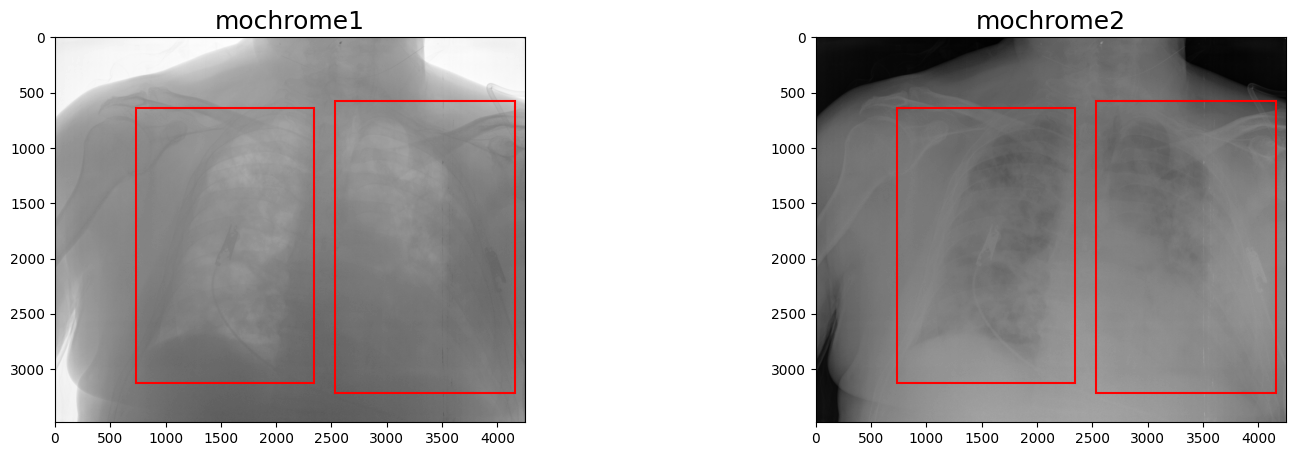

In [ ]:

ruta_im="train/20cc983e925b/9d68b678f54c/5d2ce88dc192.dcm"

def crea_ruta (ruta):
  ruta_origen="/content/drive/MyDrive/covid/"
  ruta=ruta_origen+ruta
  return ruta

def datos_imagen(ruta):
  r=crea_ruta(ruta)
  id=r.split('/')[8].replace('.dcm','')
  loc=imagen_df.loc[imagen_df['id']==id+'_image']
  return loc  

datos=datos_imagen(ruta_im)

def Visualiza_invierte(ruta,datos):
  r=crea_ruta(ruta)
  dicom=dcmread(r)
  img=dicom.pixel_array
  img=(np.maximum(img,0)/img.max())*255.0 #normaliza [0,255]
  if dicom.PhotometricInterpretation=='MONOCHROME1':
    img1=np.amax(img)-img
    fig, ax = plt.subplots(1,2,figsize=(18, 5), facecolor='w', edgecolor='b')
    axs=ax.ravel()
    axs[0].imshow(img,cmap="gray")
    axs[0].set_title('mochrome1',fontsize = 18)
    axs[1].imshow(img1,cmap="gray")
    axs[1].set_title('mochrome2',fontsize = 18)
    for i in range(2):
      if 'boxes' in datos and datos['boxes'] is not None and not pd.isna(datos['boxes']).bool():
        bboxes=literal_eval(datos['boxes'].values[0])
        for bbox in bboxes:
          rect = patches.Rectangle((bbox['x'],bbox['y']),bbox['width'],bbox['height'], linewidth=1.5, edgecolor='r', facecolor='none')
          axs[i].add_patch(rect)      
  else:
    fig, ax = plt.subplots(figsize=(18, 5), facecolor='w', edgecolor='b')
    ax.imshow(img,cmap="gray")
    if 'boxes' in datos and datos['boxes'] is not None and not pd.isna(datos['boxes']).bool():
      bboxes=literal_eval(datos['boxes'].values[0])
      for bbox in bboxes:
        rect = patches.Rectangle((bbox['x'],bbox['y']),bbox['width'],bbox['height'], linewidth=1.5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)     
  return dicom   
dicom=Visualiza_invierte(ruta_im,datos)
print(dicom)
bboxes=literal_eval(datos['boxes'].values[0])
for bbox in bboxes:
  print(bbox)

<center><h2><b>Revizando forma de los archivos</b></h2></center>
<center><h3>Los archivos tienen forma $(n,m)$ donde $n$ describe el número de renglones y $m$ el número de columnas</h3></center>

In [ ]:
#viendo forma de los documentos
print(f"imagenes de entrenamiento csv tiene forma : {imagen_df.shape}")
print(f"estudio entrenamiento csv tiene forma : {estudio_df.shape}")

imagenes de entrenamiento csv tiene forma : (6334, 4)
estudio entrenamiento csv tiene forma : (6054, 5)


<center><h2><b>Cantidad de rutas de archivos</b></h2></center>
<center><h3>Podemos ver que hay 7599 archivos 2 csv , 6334 de entrenamien y 1263 de prueba como se verá más adelante.</h3></center>

In [ ]:
################ Solo se corre una vez ###############################################
#generar txt con todas las rutas de archivos
rutas=open ('/content/drive/MyDrive/rutas.txt','w')
for dir_nom, _, arch_noms in tqdm(os.walk('/content/drive/MyDrive/covid')):
    for arch_nom in arch_noms:
        rutas.write(os.path.join(dir_nom, arch_nom)+'\n')

rutas.close()        

In [ ]:
#cargando rutas como df
rutas=pd.read_csv('/content/drive/MyDrive/rutas.txt')
todos_docs = rutas['rutas']

<center><h2><b>Visualizando algunos datos en los documentos csv</b></h2></center>

In [ ]:
rutas.head(20)

rutas
0   /content/drive/MyDrive/covid/train/1264d1caa4e...
1   /content/drive/MyDrive/covid/train/4f882088da4...
2   /content/drive/MyDrive/covid/train/71764907616...
3   /content/drive/MyDrive/covid/train/33711998b25...
4   /content/drive/MyDrive/covid/train/d274f8bf60e...
5   /content/drive/MyDrive/covid/train/ab772a1acdb...
6   /content/drive/MyDrive/covid/train/d4e34301ada...
7   /content/drive/MyDrive/covid/train/6da07da4db1...
8   /content/drive/MyDrive/covid/train/ac7371d8b32...
9   /content/drive/MyDrive/covid/train/a1a0ff86b50...
10  /content/drive/MyDrive/covid/train/956d5ff78f9...
11  /content/drive/MyDrive/covid/train/0862f314ec9...
12  /content/drive/MyDrive/covid/train/156e6297a13...
13  /content/drive/MyDrive/covid/train/0be73131305...
14  /content/drive/MyDrive/covid/train/952077ae882...
15  /content/drive/MyDrive/covid/train/ea8d3bdb207...
16  /content/drive/MyDrive/covid/train/7a15889e036...
17  /content/drive/MyDrive/covid/train/f8567c73e03...
18  /content/drive/MyDrive/covid/train/5d8bf0fa1ec...
19  /content/drive/MyDrive/covid/train/e909ea79d4a...

In [ ]:
imagen_df.head(20)

id                                              boxes  \
0   000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1   000c3a3f293f_image                                                NaN   
2   0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3   001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4   001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
5   0022227f5adf_image  [{'x': 1857.2065, 'y': 508.30565, 'width': 376...   
6   0023f02ae886_image                                                NaN   
7   002e9b2128d0_image  [{'x': 276.72917, 'y': 627.42968, 'width': 910...   
8   00326161e51e_image  [{'x': 542.96057, 'y': 364.37257, 'width': 590...   
9   0044e449aae1_image  [{'x': 1703.78756, 'y': 938.29333, 'width': 91...   
10  0049814626c8_image  [{'x': 529.25901, 'y': 832.36731, 'width': 473...   
11  004cbd797cd1_image  [{'x': 515.18569, 'y': 1170.06439, 'width': 86...   
12  0060e4f54aa8_image  [{'x': 491.36972, 'y': 1036.73739, 'width': 49...   
13  006e2ac85d57_image  [{'x': 790.41955, 'y': 514.03247, 'width': 500...   
14  007b2567d83e_image  [{'x': 281.01881, 'y': 432.78811, 'width': 823...   
15  007cf31356c6_image  [{'x': 3153.44265, 'y': 1662.61333, 'width': 9...   
16  008ca392cff3_image  [{'x': 2284.17508, 'y': 1342.64878, 'width': 1...   
17  008ff73b4ef3_image  [{'x': 609.25232, 'y': 742.45931, 'width': 115...   
18  00a129830f4e_image  [{'x': 496.23799, 'y': 1175.83357, 'width': 61...   
19  00b0891276a3_image  [{'x': 490.15248, 'y': 494.52, 'width': 722.76...   

                                                label StudyInstanceUID  
0   opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                      none 1 0 0 1 1     ff0879eb20ed  
2   opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3     opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4   opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e  
5   opacity 1 1857.2065 508.30565 2233.23384 907.8...     84543edc24c2  
6                                      none 1 0 0 1 1     2fa400b873f5  
7   opacity 1 276.72917 627.42968 1187.31776 2283....     0717c8ac304f  
8   opacity 1 542.96057 364.37257 1133.32317999999...     a81050391441  
9   opacity 1 1703.78756 938.29333 2614.8275599999...     b60f2d2cc642  
10  opacity 1 529.25901 832.36731 1002.80649999999...     4d7a2748dfb1  
11  opacity 1 515.18569 1170.06439 1378.5248700000...     30e45593ba08  
12  opacity 1 491.36972 1036.73739 982.73944 2086....     02e31620e4e7  
13  opacity 1 790.41955 514.03247 1290.60693 1779....     6f29d576794f  
14  opacity 1 281.01881 432.78811 1104.45609999999...     7f9e2766281e  
15  opacity 1 3153.44265 1662.61333 4147.52283 285...     e9d5e9c6fd14  
16  opacity 1 2284.17508 1342.64878 3307.2952 2708...     39a80a14bfda  
17  opacity 1 609.25232 742.45931 1762.01025 2478....     2c7d0327a977  
18  opacity 1 496.23799 1175.83357 1113.61823 1840...     3a3c198051f0  
19  opacity 1 490.15248 494.52 1212.91248 2100.653...     ac3d554867d0

In [ ]:
estudio_df.head(20)

id  Negative for Pneumonia  Typical Appearance  \
0   00086460a852_study                       0                   1   
1   000c9c05fd14_study                       0                   0   
2   00292f8c37bd_study                       1                   0   
3   005057b3f880_study                       1                   0   
4   0051d9b12e72_study                       0                   0   
5   00792b5c8852_study                       1                   0   
6   00908ffd2d08_study                       1                   0   
7   009bc005edaa_study                       0                   0   
8   00a76543ed93_study                       0                   0   
9   00a87235ca36_study                       0                   1   
10  00b33b3eb8d9_study                       0                   1   
11  00c241c3fc0d_study                       1                   0   
12  00c74279c5b7_study                       1                   0   
13  00c83e33588f_study                       0                   0   
14  00ccd633fb0e_study                       1                   0   
15  00e936c58da6_study                       1                   0   
16  00f9e183938e_study                       0                   0   
17  00fceac64e6a_study                       0                   0   
18  00febcfee50b_study                       1                   0   
19  011475cb6db4_study                       1                   0   

    Indeterminate Appearance  Atypical Appearance  
0                          0                    0  
1                          0                    1  
2                          0                    0  
3                          0                    0  
4                          0                    1  
5                          0                    0  
6                          0                    0  
7                          1                    0  
8                          1                    0  
9                          0                    0  
10                         0                    0  
11                         0                    0  
12                         0                    0  
13                         1                    0  
14                         0                    0  
15                         0                    0  
16                         0                    1  
17                         1                    0  
18                         0                    0  
19                         0                    0

<center><h2><b>Cantidad y porcentaje por categoria etiquetada en los estudios</b></h2></center>

In [ ]:
#agrupando todos los estudios en sus categorias 

grupos_estudios = pd.melt(estudio_df, id_vars=list(estudio_df.columns)[:1], value_vars=list(estudio_df.columns)[1:],
             var_name='etiqueta', value_name='valor')
grupos_estudios = grupos_estudios.loc[grupos_estudios['valor']!=0]
grupos_estudios = grupos_estudios.groupby('etiqueta').sum().sort_values('valor',ascending=False).reset_index()
grupos_estudios['porcentaje']= round((grupos_estudios['valor'] / grupos_estudios['valor'].sum())*100,2) # porcentaje por categoria
grupos_estudios.head(4)

etiqueta  valor  porcentaje
0        Typical Appearance   2855       47.16
1    Negative for Pneumonia   1676       27.68
2  Indeterminate Appearance   1049       17.33
3       Atypical Appearance    474        7.83

<center><h2><b>Graficando Porcentajes</b></h2></center>

In [ ]:
#graficando porcentaje de estudios por categoria 
colores = {'Typical Appearance' : '#226666',
'Negative for Pneumonia' : '#532B72',
'Indeterminate Appearance' : '#AAA639',
          'Atypical Appearance' : '#AA6C39'
         }

grupos_estudios['colores'] = grupos_estudios['etiqueta'].apply(lambda x: colores[x])

fig = go.Figure(data=[go.Pie(labels=grupos_estudios['etiqueta'],
                             values=grupos_estudios['porcentaje'],
                             hole=.3,
                             pull=[0.1, 0.1, 0.1, 0.1]
                            )
                     ]
               )

fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=16,
                  marker=dict(colors=grupos_estudios['colores'], line=dict(color='#000000', width=2))
                 )

fig.update_layout(title={'text': "% de etiquetas en el set de entrenamiento",
        'y':0.9,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()
     

<center><h2><b>Cantidad de imagenes segun la clase</b></h2></center>

In [ ]:
#clases por imagenes 
imagen_df['class'] = imagen_df.label.apply(lambda x: x.split()[0])
imagenes_grupo=imagen_df.groupby(['class']).size().reset_index(name='counts')
imagenes_grupo

class  counts
0     none    2040
1  opacity    4294

<center><h2><b>Visualización de distribución para las etiquetas de estudios</b></h2></center>

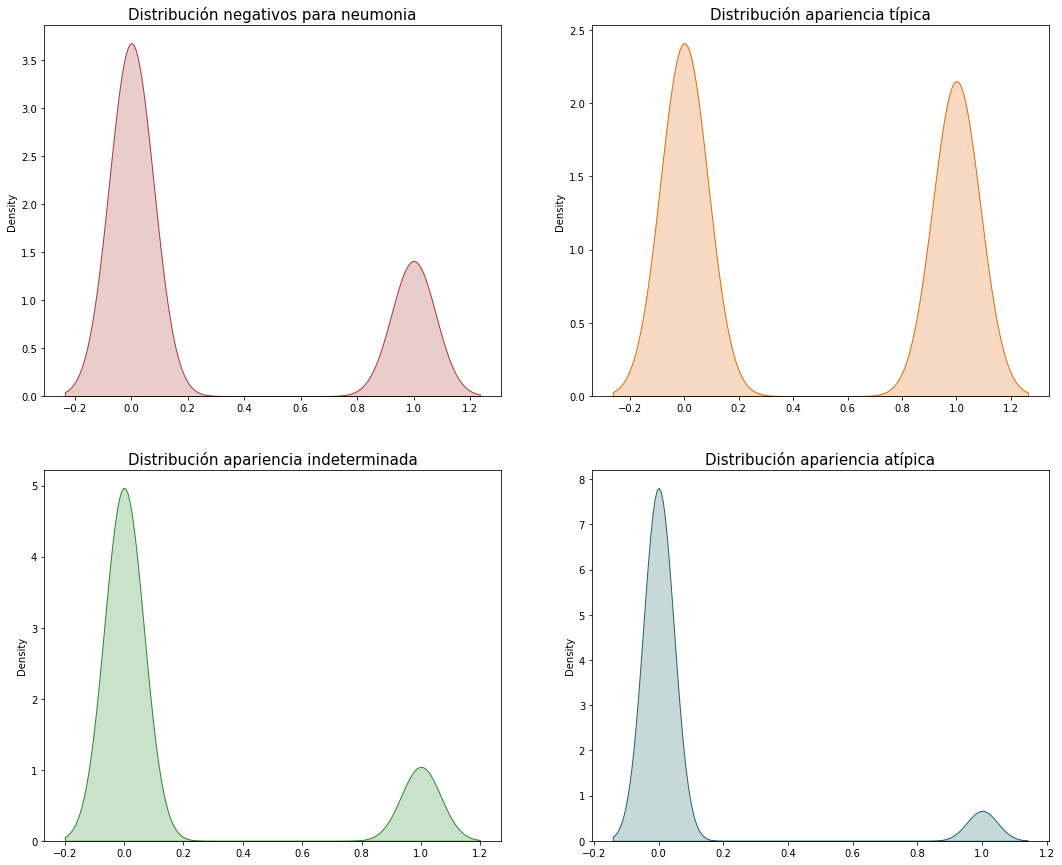

In [ ]:
#distribuciones para las clases de etiquetado
fig, ax = plt.subplots(2,2,figsize=(18,15))
sns.kdeplot(estudio_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#AA3939")
ax[0,0].set_title("Distribución negativos para neumonia", fontsize=15)
ax[0,0].set(xlabel=None)
sns.kdeplot(estudio_df["Typical Appearance"], shade=True,ax=ax[0,1],color="#E26B09")
ax[0,1].set_title("Distribución apariencia típica", fontsize=15)
ax[0,1].set(xlabel=None)
sns.kdeplot(estudio_df["Indeterminate Appearance"], shade=True,ax=ax[1,0],color="#2D882D")
ax[1,0].set_title("Distribución apariencia indeterminada", fontsize=15)
ax[1,0].set(xlabel=None)
sns.kdeplot(estudio_df["Atypical Appearance"], shade=True,ax=ax[1,1],color="#226666")
ax[1,1].set_title("Distribución apariencia atípica", fontsize=15)
ax[1,1].set(xlabel=None)
plt.show()

<center><h2><b>Visualizando metadatos de una imagen</b></h2></center>

In [ ]:
ruta_raiz="/content/drive/MyDrive/covid"
#archivo cualquiera
ruta_archivo=ruta_raiz+"/train/0a1a3dd9e738/79de130ea278/64a776818efe.dcm"
#veamo los metadatos en la primera imagen
metadatos = read_file(ruta_archivo, stop_before_pixels=False)
print(metadatos)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.8235321319553264525788637361230761897
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 64a776818efe
(0008, 0020) Study Date                          DA: '3108070a6130'
(0008, 0030) Study Time                          TM: '6de8b3f972d5'
(0008, 0050) Accession Number                    SH: 'f5b6c4c719d5'
(0008, 0060) Modality                            CS: 'DX'
(0009, 0010) Private Creator                     LO: 'GEIIS'
(0010, 0010

/usr/local/lib/python3.8/dist-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: '71228e4340de'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.

/usr/local/lib/python3.8/dist-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: '64a776818efe'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.

/usr/local/lib/python3.8/dist-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: '0a1a3dd9e738'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.

/usr/local/lib/python3.8/dist-packages/pydicom/valuerep.py:290: UserWarning:

Invalid value for VR UI: '79de130ea278'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.



In [ ]:
#pasando archivo como arreglo 
meta=metadatos.pixel_array
#veamos su tipo y forma
print("tipo= ",type(meta))
print("forma= ",meta.shape)

<center><h2><b>Pasando imagen a matriz de pixceles para ver su forma</b></h2></center>
<center><h3>La imagen tiene forma $(n,m,c)$ donde $n$ representa el número de pixeles a lo alto y $m$ el número de pixeles a lo largo y $c$ los canales.</h3></center>

forma imagen:  (3480, 4248, 3)


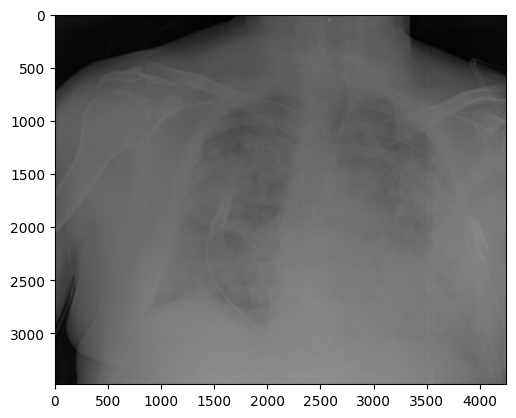

In [ ]:
#ruta de imagen aleatoria png
ruta='/content/drive/MyDrive/covid/train/20cc983e925b/9d68b678f54c/5d2ce88dc192.png'
imagen=cv2.imread(ruta)
plt.imshow(imagen)
print('forma imagen: ',imagen.shape)

<center><h2><b>Visualizando una imagen para cada etiqueta en los estudios</b></h2></center>

In [ ]:
#definamos funcion que para cada clase de etiquetas tome N elementos

def toma_muestras(num):
    grupos_estudios_df = pd.melt(estudio_df, id_vars=list(estudio_df.columns)[:1], value_vars=list(estudio_df.columns)[1:],
             var_name='etiqueta', value_name='valor')
    grupos_estudios_df = grupos_estudios_df.loc[grupos_estudios_df['valor']!=0].reset_index(drop=True)
    etiquetas = list(grupos_estudios_df['etiqueta'].unique())
    estudio_muestra = {}
    for etiqueta in etiquetas:
        #opteniendo numero de renglones muestra del df
        ids_estudio = grupos_estudios_df.loc[grupos_estudios_df['etiqueta'] == etiqueta].sample(num)['id'].tolist() 
        muestras = []
        for id_estudio in ids_estudio:
            imagen = {}
            instancia_estudio_id = id_estudio.split('_')[0]
            #Obteniendo la imagen que coincide con el id de estudio
            id_imagen = imagen_df.loc[imagen_df['StudyInstanceUID']==instancia_estudio_id]['id'].values[0].split('_')[0] 
            nombre_archivo = [cadena for cadena in todos_docs if id_imagen in cadena]
            imagen['id_estudio'] = instancia_estudio_id
            imagen['archivo_dicom'] = nombre_archivo[0]
            #Obteniendo recuadros de daño 
            caja = None
            try:
                caja = literal_eval(imagen_df.loc[imagen_df['StudyInstanceUID']==instancia_estudio_id]['boxes'].values[0])
            except ValueError:
                pass
            imagen['boxes'] = caja
            muestras.append(imagen)
        estudio_muestra[etiqueta] = muestras
    return estudio_muestra

In [ ]:
#funcion que muestra una imagen de cada clase
def visualiza_muestras():
    todas_clases = []
    for indice in muestras:
        muestra_dict = muestras[indice][0]
        muestra_dict['clase'] = indice
        todas_clases.append(muestra_dict)
    fig1, ax1 = plt.subplots(1,4, figsize=(18, 5), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    nom=''
    for item, ax in zip(todas_clases, axs):
        dicom = read_file(item['archivo_dicom'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if 'boxes' in item and item['boxes'] is not None:
            for caja in item['boxes']:             
                rect = patches.Rectangle((caja['x'], caja['y']), caja['width'], caja['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        if item['clase']== "Negative for Pneumonia":
          nom="Negativo para neumonia"
        elif item['clase']== "Typical Appearance":
          nom="Apariencia Típica"
        elif item['clase']== "Indeterminate Appearance":
          nom="Apariencia Indeterminada"
        else:
          nom="Apariencia Atípica"            
        ax.set_title('{}'.format(nom),fontsize = 18)    
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('muestras de todas las categorias',fontsize = 20)
    plt.show()



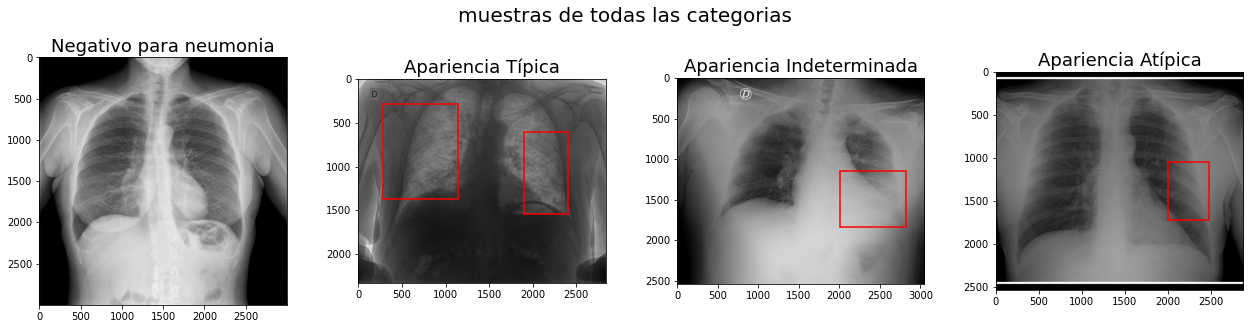

In [ ]:
#ejecutando funciones
muestras = toma_muestras(6) 
visualiza_muestras()

<center><h2><b>Visualizando muestra de imagenes de cada etiqueta y su grafico por pixel</b></h2></center>
<center><h3>Una imagen se ve como matriz de $(n,m)$ donde se guarda el valor de rango del pixel,calculado en función la profundidad de bits que cuantifica cuántos colores únicos están disponibles en la paleta de colores de una imagen en términos de la cantidad bits, que se utilizan para especificar cada color.<br>
El rango de valores por pixel se calcula por $[0,2^d-1]$ donde $d$ es la profundidad de bits, por ejemplo, en una imagen de 8-bits cada pixel puede tomar valores en $[0,2^{8}-1]=[0,255]$, así: </h3></center>




<center><h3>En este caso las imagenes estan en 16 bits por lo que cada pixel esta en el rango de $[0,2^{16}-1]=[0,65535]$</h3></center>

In [ ]:
#funcion que muestra de una sola clase
def visualiza_clase(clase, titulo, dibuja_cajas=False):

    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(clase, axs):
        dicom = read_file(item['archivo_dicom'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if dibuja_cajas == True and item['boxes'] is not None:
            for caja in item['boxes']:             
                rect = patches.Rectangle((caja['x'], caja['y']), caja['width'], caja['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Studio : {}'.format(item['id_estudio']),fontsize = 18)
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle(titulo,fontsize = 20)
    plt.show()

In [ ]:
#funcion que despliega histograma de cada imagen  respecto a pixel
def muestra_histograma(muestras, titulo):
    fig1, ax1 = plt.subplots(2,3, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(muestras, axs):
        #Carga archivo dicom 
        dicom = read_file(item['archivo_dicom'], stop_before_pixels=False)
        #numpy.ndarray que contiene datos por pixel,ie, matrices (n,m) con n y m variables 
        #de inicio las imagenes son de distintos tamalos cada dato esta en [0,65535]=[0,2^16-1] rango de pixeles
        img = dicom.pixel_array
        #crea vector unidimensional con valor de pixel de longitud n*m
        sub_plot = sns.histplot(img.flatten(), ax=ax)
        ax.set_title('Estudio : {}'.format(item['id_estudio']),fontsize = 18)
        ax.set(xlabel = 'rango de pixel',ylabel = 'conteo')
        
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle('Histograma para imagen - {}'.format(titulo),fontsize = 20)
    plt.show()



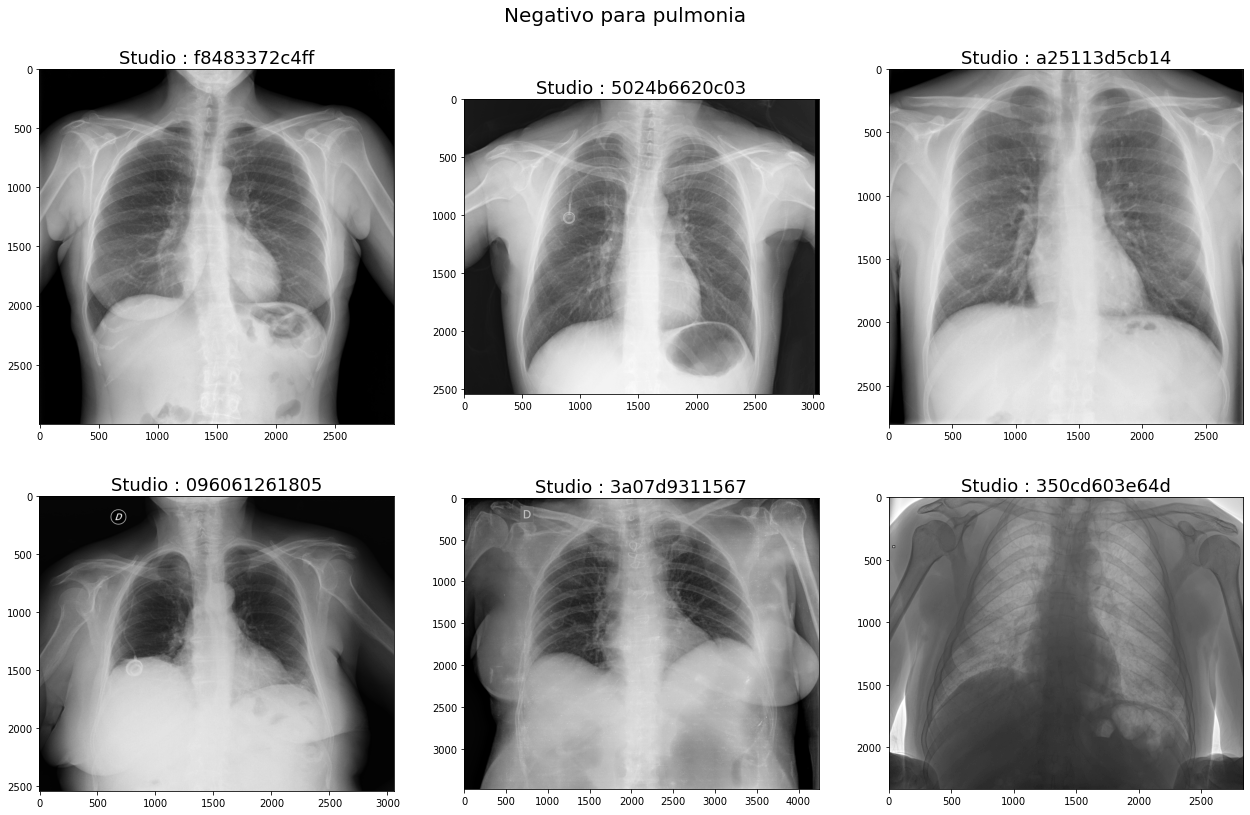

In [ ]:
#visualizando negativos para pulmonia
visualiza_clase(muestras['Negative for Pneumonia'],'Negativo para pulmonia')

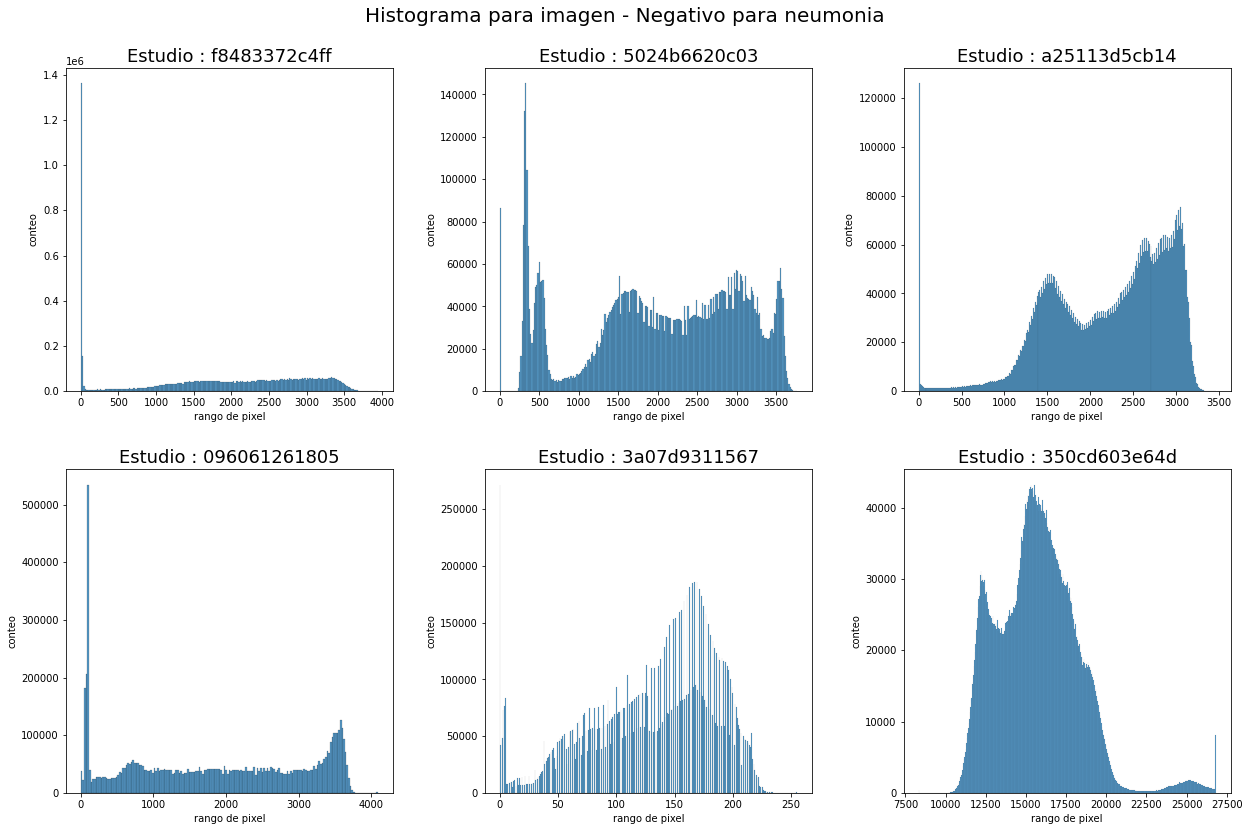

In [ ]:
muestra_histograma(muestras['Negative for Pneumonia'],'Negativo para neumonia')

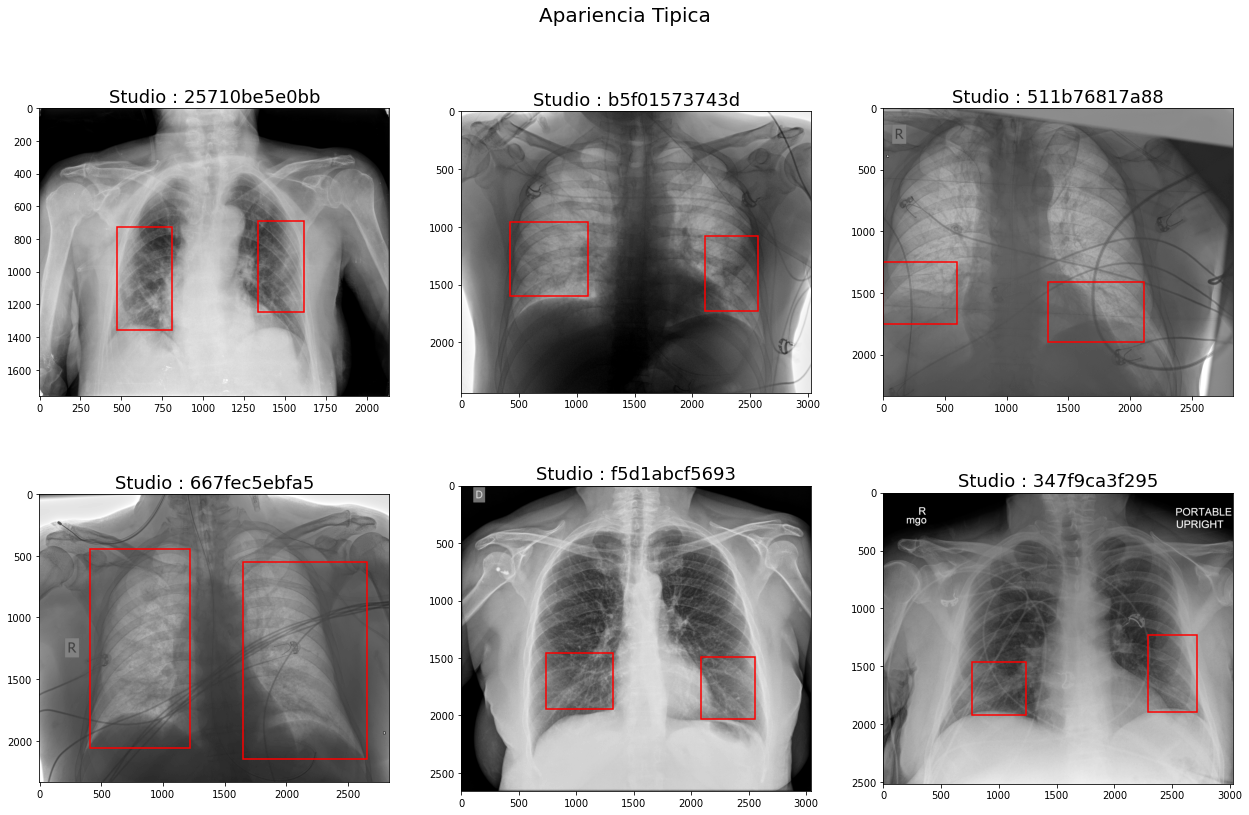

In [ ]:
#visualizando los de apariencia typica
visualiza_clase(muestras['Typical Appearance'],'Apariencia Tipica', dibuja_cajas=True)

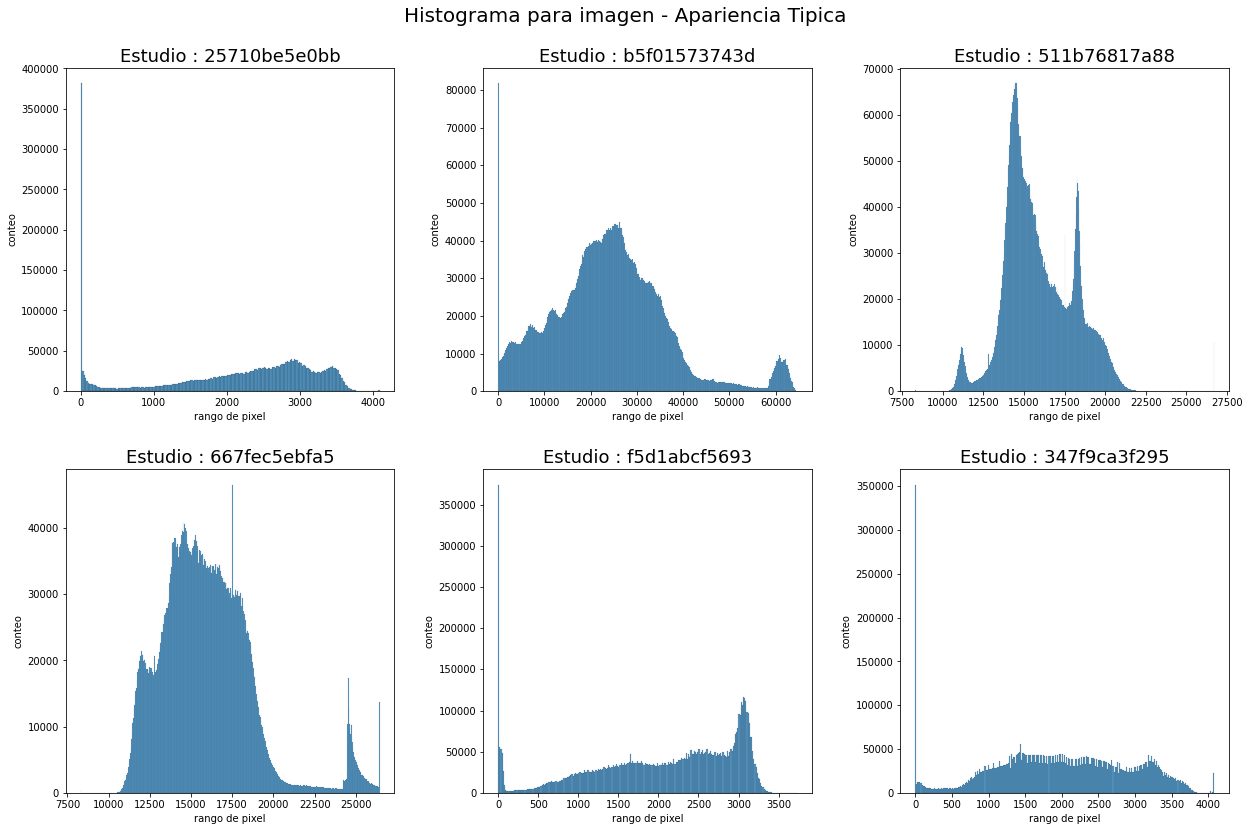

In [ ]:
#visualizando histograma de apariencia tipica
muestra_histograma(muestras['Typical Appearance'],'Apariencia Tipica')

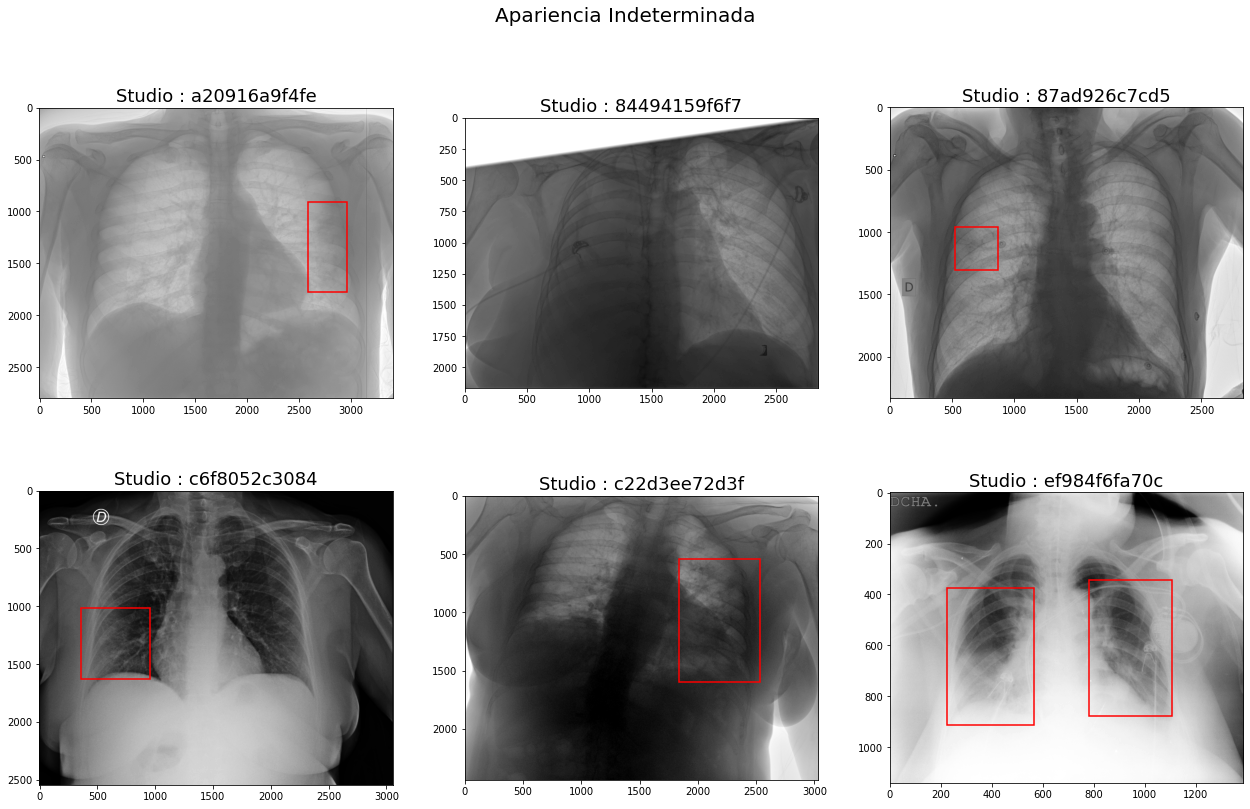

In [ ]:
#visualizando lo de apariencia indeterminada
visualiza_clase(muestras['Indeterminate Appearance'],'Apariencia Indeterminada', dibuja_cajas=True)

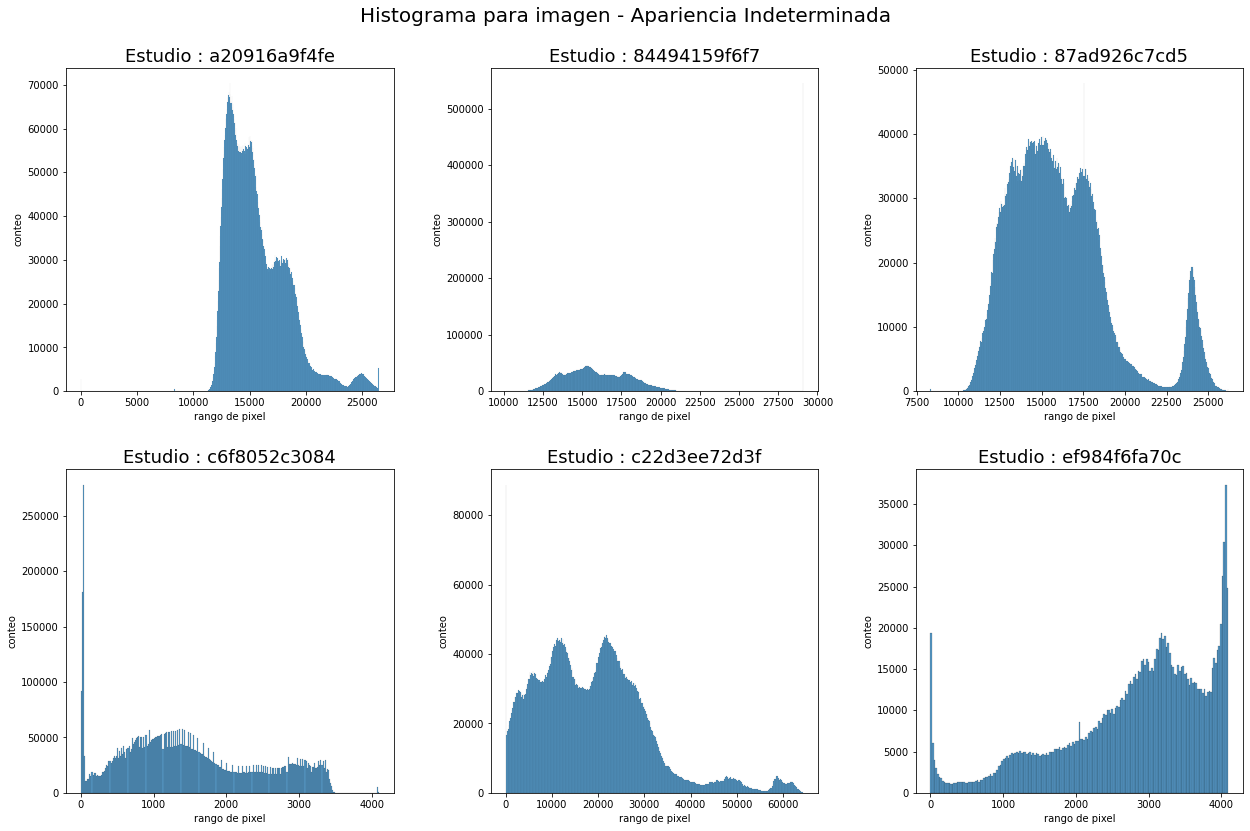

In [ ]:
#viendo histograma de pixeles 
muestra_histograma(muestras['Indeterminate Appearance'],'Apariencia Indeterminada')

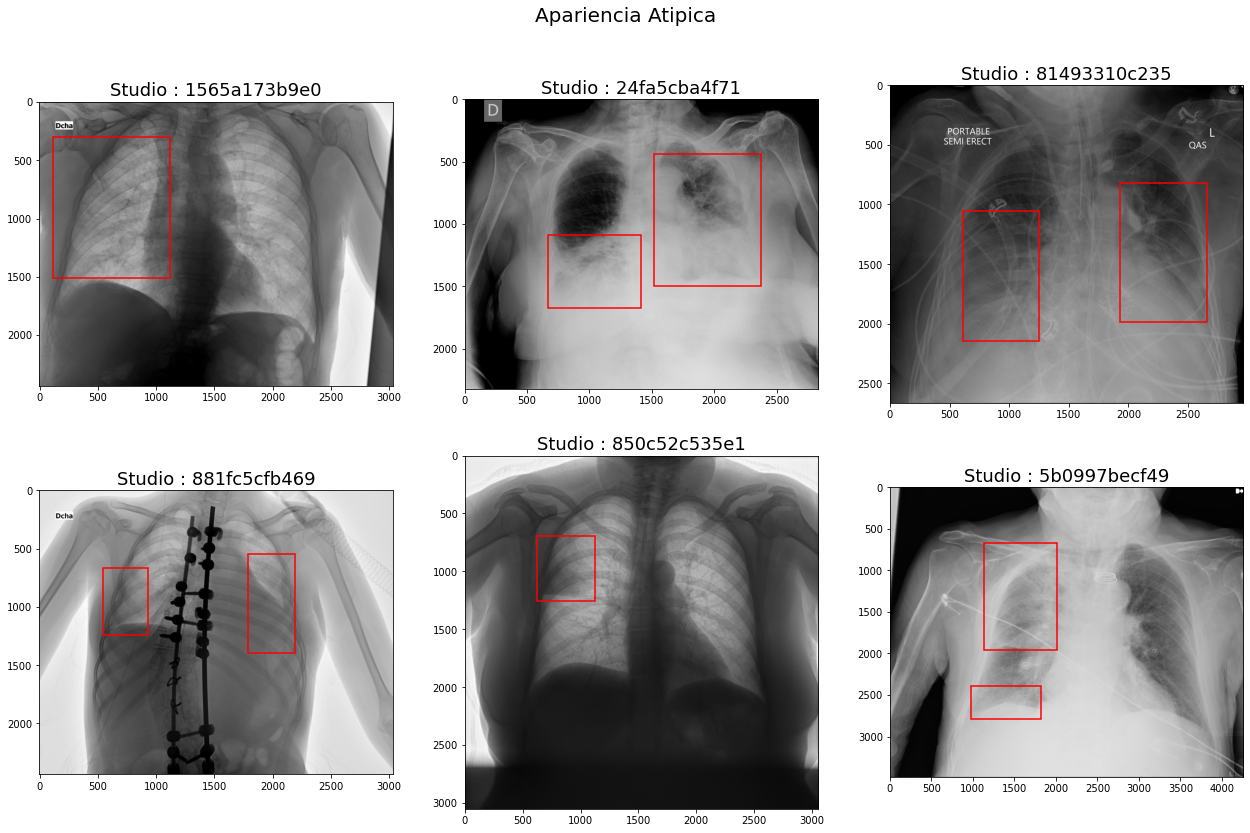

In [ ]:
#visualizando los de apariencia atipica
visualiza_clase(muestras['Atypical Appearance'],'Apariencia Atipica', dibuja_cajas=True)

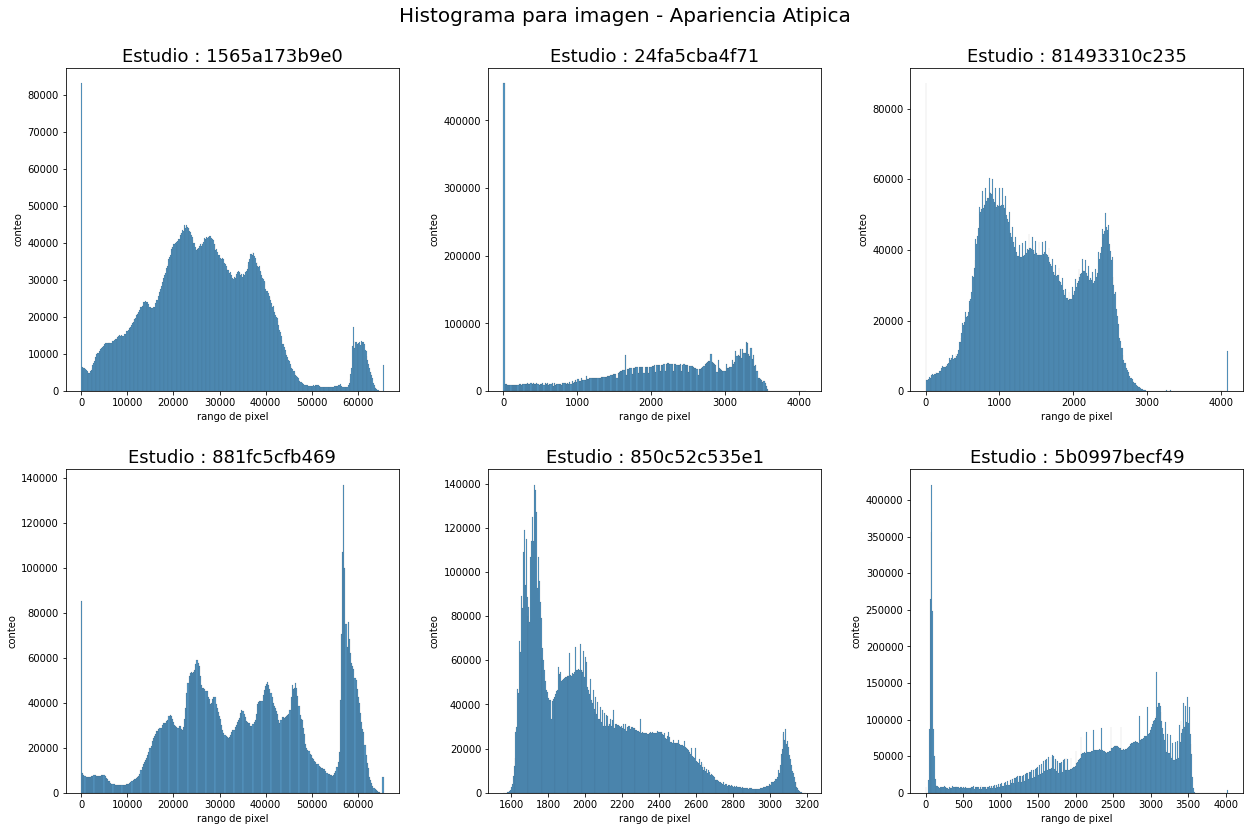

In [ ]:
#histograma de pixeles para apariencia atipica
muestra_histograma(muestras['Atypical Appearance'],'Apariencia Atipica')

<center><h2><b>Pasando metadatos de datos de entrenamiento a dataframe</b></h2></center>

In [ ]:
#funcion que trae archivos de un tipo (train o test)
def obtiene_archivos(tipo):
    archivos=[]
    for archivo in todos_docs:
        if tipo in archivo:
            archivos.append(archivo)
    return archivos

In [ ]:
#obteniendo archivos de entrenamiento y prueba
archivos_entrenamiento = obtiene_archivos('/train/')
archivos_prueba=obtiene_archivos('/test/')

In [ ]:
print(f"Cantidad de datos de entrenamiento : {len(archivos_entrenamiento)}")
print(f"Cantidad de datos de prueba : {len(archivos_prueba)}")

Cantidad de datos de entrenamiento : 6334
Cantidad de datos de prueba : 1263


In [ ]:
#obteniendo metadatos 
#acceder por tags a metadatos
pv_creador1 = Tag(0x2001, 0x10) #creador privado 1
pv_creador2 = Tag(0x0903, 0x10) #creador privado 2

#columnas de metadatos
columnas = [ 'StudyID',
 'StudyInstanceUID',
 'PatientSex', 
 'BitsAllocated',
 'BitsStored',
 'Columns',
 'Rows',
 'BodyPartExamined', 
 'HighBit', 
 'ImageType',
 'ImagerPixelSpacing',
 'InstanceNumber',
 'Modality',
 'PatientID',
 'PatientName',
 'AccessionNumber',
 'DeidentificationMethod',
 'PhotometricInterpretation',
 'PixelRepresentation',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyTime',
 'PrivateCreator1',
 'PrivateCreator2']

In [ ]:
################### Solo se ejecuta una vez ####################################
#funcion que extrae metadatos
def extrae_metadatos(columnas, documentos):
    df = pd.DataFrame(columns=columnas)
    for num, documento in tqdm(enumerate(documentos)):
        renglon = {}
        dicom_img = read_file(documento, stop_before_pixels=True)
        for columna in columnas:
            if columna not in ['PrivateCreator1', 'PrivateCreator2']:
                renglon[columna] = dicom_img[columna].value
        try:        
            renglon['PrivateCreator1'] = dicom_img.get_item(pv_creador1).value
            renglon['PrivateCreator2'] = dicom_img.get_item(pv_creador2).value    
        except AttributeError:
            pass
        df = df.append(renglon,ignore_index=True)
    return df

In [ ]:
####################### Solo se ejecuta una vez #################################
entrena_df_md = extrae_metadatos(columnas,archivos_entrenamiento )

In [ ]:
################ Solo se ejecuta una vez ##############################
#guardando en csv
entrena_df_md.to_csv('/content/drive/MyDrive/metadatos_entrenamiento.csv',index=False,sep=',')

In [ ]:
################# Solo se ejecuta una vez #################################
prueba_df_md = extrae_metadatos(columnas, archivos_prueba)

In [ ]:
################################ Solo se ejecuta una vez ####################################################
#guardando en csv
prueba_df_md.to_csv('/content/drive/MyDrive/metadatos_prueba.csv',index=False,sep=',')

In [ ]:
#metadatos de archivos de entrenamiento
entrena_df_md=pd.read_csv('/content/drive/MyDrive/metadatos_entrenamiento.csv')
entrena_df_md.head(10)

StudyID StudyInstanceUID PatientSex  BitsAllocated  BitsStored  \
0  55625fb42f3f     1264d1caa4ec          F             16          15   
1  55625fb42f3f     4f882088da4b          M             16          15   
2  55625fb42f3f     717649076168          M             16          12   
3  55625fb42f3f     33711998b257          F             16          15   
4  55625fb42f3f     d274f8bf60e5          M             16          12   
5  55625fb42f3f     ab772a1acdbf          F             16          12   
6  55625fb42f3f     d4e34301adad          M             16          12   
7  55625fb42f3f     6da07da4db19          M             16          12   
8  55625fb42f3f     ac7371d8b321          M             16          15   
9  55625fb42f3f     a1a0ff86b50f          M             16          12   

   Columns  Rows BodyPartExamined  HighBit                ImageType  ...  \
0     3408  2800            CHEST       14  ['ORIGINAL', 'PRIMARY']  ...   
1     2836  2336            CHEST       14  ['ORIGINAL', 'PRIMARY']  ...   
2     3488  3488            CHEST       11  ['ORIGINAL', 'PRIMARY']  ...   
3     4248  3480            CHEST       14  ['ORIGINAL', 'PRIMARY']  ...   
4     4240  3480            CHEST       11  ['ORIGINAL', 'PRIMARY']  ...   
5     1387  1140            CHEST       11  ['ORIGINAL', 'PRIMARY']  ...   
6     2872  2780            SKULL       11  ['ORIGINAL', 'PRIMARY']  ...   
7     3056  2544            CHEST       11   ['DERIVED', 'PRIMARY']  ...   
8     2836  2336            CHEST       14  ['ORIGINAL', 'PRIMARY']  ...   
9     4240  3480            CHEST       11  ['ORIGINAL', 'PRIMARY']  ...   

    SOPClassUID  SOPInstanceUID SamplesPerPixel SeriesInstanceUID  \
0  71228e4340de    53488579be26               1      5db0b9e34fa0   
1  03a65300fa41    93a09edfd468               1      2697968e7739   
2  71228e4340de    39748831cb0e               1      e1660f6229e5   
3  03a65300fa41    bb2dbf6eeb2f               1      ffdf7ce3d6e8   
4  03a65300fa41    4c0af9bef102               1      1923c48048e7   
5  03a65300fa41    b89ad152da0f               1      092dbbfe29bd   
6  03a65300fa41    ab03f7662b1d               1      d1e219680d0a   
7  71228e4340de    b2e6aaa32f81               1      1b5c3c332098   
8  03a65300fa41    a159880ddb87               1      ba6382ff61bd   
9  03a65300fa41    f11d8993a22d               1      e418e3d8aca6   

  SeriesNumber SpecificCharacterSet     StudyDate     StudyTime  \
0          1.0           ISO_IR 100  08beba8120bf  126cd69fd550   
1          1.0           ISO_IR 100  836cb55aaca1  c45f4b5e2266   
2          1.0           ISO_IR 100  233953e200d9  76906b2247e6   
3          1.0           ISO_IR 192  7e825928c7af  f3754d348498   
4          1.0           ISO_IR 100  2673cee2a931  eb30c7cd762b   
5          1.0           ISO_IR 100  c81e1f6ba716  5e539b5ccf35   
6          1.0           ISO_IR 100  5545bf4773f8  73e451976568   
7          1.0           ISO_IR 100  70d88cf1eef1  11672620075d   
8          1.0           ISO_IR 100  837af68926b7  ee45bb66739d   
9          1.0           ISO_IR 100  d99077eb7605  b6b648734199   

             PrivateCreator1 PrivateCreator2  
0                        NaN             NaN  
1                        NaN             NaN  
2                        NaN             NaN  
3                        NaN             NaN  
4                        NaN             NaN  
5                        NaN             NaN  
6  b'Philips Imaging DD 001'   b'GEIIS PACS'  
7                        NaN             NaN  
8                        NaN             NaN  
9                        NaN             NaN  

[10 rows x 29 columns]

<center><h2><b>Conteo por sexo y parte del cuerpo en los datos de entrenamiento</b></h2></center>

In [ ]:
#generos de datos de entrenamiento
entrena_df_md['PatientSex'].value_counts().reset_index()

index  PatientSex
0     M        3564
1     F        2770

In [ ]:
#partes del cuerpo datos de entrenamiento
entrena_df_md['BodyPartExamined'].value_counts().reset_index()

index  BodyPartExamined
0        CHEST              5050
1        TORAX               307
2   PORT CHEST               249
3        T?RAX               156
4       THORAX                77
5        SKULL                57
6        Pecho                21
7      ABDOMEN                21
8     2- TORAX                 7
9        TÒRAX                 5
10       PECHO                 3

<center><h2><b>Pasando metadatos de datos de prueba a dataframe</b></h2></center>

In [ ]:
#metadatos de archivos de prueba
prueba_df_md=pd.read_csv('/content/drive/MyDrive/metadatos_prueba.csv')
prueba_df_md.head(10)

StudyID StudyInstanceUID PatientSex  BitsAllocated  BitsStored  \
0  55625fb42f3f     fd15cbd7cced          F             16          15   
1  55625fb42f3f     080ea6634d62          F             16          15   
2  55625fb42f3f     43d60e93cbf3          F             16          15   
3  55625fb42f3f     9e4fbb2efbf9          F              8           8   
4  55625fb42f3f     240db28d224f          F             16          12   
5  55625fb42f3f     db4af70e370f          M             16          12   
6  55625fb42f3f     def217a20092          F             16          12   
7  55625fb42f3f     8a6902767de9          F             16          12   
8  55625fb42f3f     1a77f709c788          M             16          12   
9  55625fb42f3f     33e1be3d2bae          F             16          15   

   Columns  Rows BodyPartExamined  HighBit  \
0     2836  2336            CHEST       14   
1     2836  2336            CHEST       14   
2     2550  2336            CHEST       14   
3     2832  2320            CHEST        7   
4     3056  2544       PORT CHEST       11   
5     4240  3480            CHEST       11   
6     3052  2996            CHEST       11   
7     2990  2701              NaN       11   
8     4240  3480            CHEST       11   
9     2836  2336            CHEST       14   

                                       ImageType  ...   SOPClassUID  \
0                        ['ORIGINAL', 'PRIMARY']  ...  71228e4340de   
1                        ['ORIGINAL', 'PRIMARY']  ...  71228e4340de   
2                        ['ORIGINAL', 'PRIMARY']  ...  71228e4340de   
3                        ['ORIGINAL', 'PRIMARY']  ...  03a65300fa41   
4                         ['DERIVED', 'PRIMARY']  ...  71228e4340de   
5                        ['ORIGINAL', 'PRIMARY']  ...  03a65300fa41   
6                        ['ORIGINAL', 'PRIMARY']  ...  71228e4340de   
7  ['DERIVED', 'SECONDARY', '', 'CSA RESAMPLED']  ...  03a65300fa41   
8                        ['ORIGINAL', 'PRIMARY']  ...  03a65300fa41   
9                        ['ORIGINAL', 'PRIMARY']  ...  03a65300fa41   

   SOPInstanceUID SamplesPerPixel SeriesInstanceUID SeriesNumber  \
0    2f9ccb6faa68               1      14761fbe27fb          1.0   
1    29c992128fbd               1      e06c384e10b8          1.0   
2    4ccb8a39c77a               1      e31e7746f5fe          1.0   
3    08bbffaafbe7               1      3761202a6e55          1.0   
4    ca7b91d018c7               1      28f984461911          1.0   
5    bf8e59f80d5c               1      dc9dd2e17a5b          1.0   
6    2a2f54eb48df               1      6d07de536f93          1.0   
7    ffb8115a304c               1      69cd841207cf          1.0   
8    9310ceec556a               1      ec494b52ed1d          1.0   
9    aee5e3feb1a2               1      aaefde8f5ca0          1.0   

  SpecificCharacterSet     StudyDate     StudyTime  PrivateCreator1  \
0           ISO_IR 100  11162be19d39  a66550f14de8              NaN   
1           ISO_IR 100  c888eed0cd86  37ba9b388ba0              NaN   
2           ISO_IR 100  637df68fbaf4  bf813ab1487c              NaN   
3           ISO_IR 100  1c32dde11675  ee2f854b7c4b              NaN   
4           ISO_IR 100  837af68926b7  12d2739864b0              NaN   
5           ISO_IR 100  2fb8dbe78524  d20a2d6e98c7              NaN   
6           ISO_IR 100  0fcb8e63147a  b78625d7fc52              NaN   
7           ISO_IR 100  11162be19d39  c99ba3821f72              NaN   
8           ISO_IR 100  445a5343ecda  7240963ffa49              NaN   
9           ISO_IR 100  d99077eb7605  86f3f14863fa              NaN   

  PrivateCreator2  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5             NaN  
6             NaN  
7             NaN  
8             NaN  
9             NaN  

[10 rows x 29 columns]

<center><h2><b>Conteo por sexo y parte del cuerpo en los datos de prueba</b></h2></center>

In [ ]:
#generos de datos de prueba
prueba_df_md['PatientSex'].value_counts().reset_index()

index  PatientSex
0     M         745
1     F         518

In [ ]:
#partes del cuerpo datos de prueba
prueba_df_md['BodyPartExamined'].value_counts().reset_index()

index  BodyPartExamined
0        CHEST              1005
1   PORT CHEST                70
2        TORAX                64
3        T?RAX                25
4        SKULL                13
5       THORAX                10
6      ABDOMEN                 4
7        Pecho                 3
8        PECHO                 2
9     2- TORAX                 1
10       TÒRAX                 1

<center><h2><b>Graficando tamaños de imagenes respecto a pixeles por renglón y columna</b></h2></center>

In [ ]:
#graficar relaciones de tamaños de imagenes de entrenamiento
entrena_df_md['BitsStored'] = entrena_df_md['BitsStored'].astype(int)
def combina_tamaño_imagen(renglon):
    return str(renglon['Rows']) + ',' + str(renglon['Columns'])
entrena_df_md['ImageSize'] = entrena_df_md.apply(lambda x: combina_tamaño_imagen(x), axis=1)

In [ ]:
fig = go.Figure(go.Scattergl(
    x=entrena_df_md['Rows'], y=entrena_df_md['Columns'],
    name='Tamaño de Imagen',
    mode='markers',  
    marker=dict(
        color='#0092CC',
    )
))
fig.update_layout(xaxis={'title' : 'Renglones', 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Columnas'},
                      showlegend=False,
                     title = 'Tamaño imagenes de entrenamiento')
fig.update_traces(textfont_size=16)
fig.show()

In [ ]:
fig = go.Figure(go.Scattergl(
    x=prueba_df_md['Rows'], y=prueba_df_md['Columns'],
    name='Tamaño de imagen',
    mode='markers',  
    marker=dict(
        color='#DCD427',
    )
))
fig.update_layout(xaxis={'title' : 'Renglones', 
                             'showgrid':False},
                      yaxis={'showgrid':False,
                            'title' : 'Columnas'},
                      showlegend=False,
                     title = 'Tamaño imagenes de Prueba')
fig.update_traces(textfont_size=16)
fig.show()

<center><h2><b>Diagrama de caja para tamaños</b></h2></center>

In [ ]:
#diagrama de caja de tamaños de imagen
entrena_df_md['ImageSize'] = entrena_df_md['Rows'] *entrena_df_md['Columns']
prueba_df_md['ImageSize'] = prueba_df_md['Rows'] * prueba_df_md['Columns']

fig = go.Figure()
fig.add_trace(go.Box(y=entrena_df_md['ImageSize'], 
                         name='Entrenamiento', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor='#0918A8',
                         marker_size=5,
                         line_width=1))
fig.add_trace(go.Box(y=prueba_df_md['ImageSize'], 
                         name='Prueba', 
                         jitter=0.5,
                         whiskerwidth=0.6,
                         fillcolor='#CF130E',
                         marker_size=5,
                         line_width=1))

fig.update_layout(xaxis={'title' : None,'showgrid' :False},
                  yaxis=dict(title='Tamaño de imagen (Pixeles)',showgrid=False,zeroline=False),
                 title = 'Tamaño de imagen quartiles')    
fig.show()

<center><h2><b>Cantidad de imagenes según su modalidad</b></h2></center>
<center><h3>Existen dos modalidades:
<lu>
<li>CR - Computed Radiography (Radiografía computarizada)</li>
<li>DX - Digital Radiography(Radiografía digital)</li>
</lu>
<b>Radiografía computarizada:</b>es el uso de una placa de imágenes de fósforo para crear una imagen digital. CR utiliza un sistema basado en casetes como la película analógica.<br>
<b>Radiografía digital:</b>es el último avance en el campo de la radiografía y utiliza un detector de rayos X digital para adquirir imágenes automáticamente y transferirlas a una computadora para su visualización. Este sistema también es capaz de uso fijo o móvil.

</h3></center>


In [ ]:
#DICOM tiene un atributo llamado "Modalidad". Esto describe la tecnología utilizada para capturar las imágenes de radiografía. 
#CR - Radiografía computarizada 
#DX - Radiografía digital

#relacion de modalidad
modalidad_entrena = entrena_df_md['Modality'].value_counts().reset_index().rename(columns={'index':'Modality','Modality':'Count'})
modalidad_entrena['Type'] = 'Entrenamiento'
modalidad_prueba = prueba_df_md['Modality'].value_counts().reset_index().rename(columns={'index':'Modality','Modality':'Count'})
modalidad_prueba['Type'] = 'Prueba'
modalidad_df = pd.concat([modalidad_entrena, modalidad_prueba]).reset_index(drop=True)
modalidad_map = {'DX' : 'Digital Radiography',
'CR' : 'Computed Radiography'}
modalidad_df['Desc'] = modalidad_df['Modality'].apply(lambda x : modalidad_map[x])
bar_colors = ['#0918A8', '#CF130E']
modalidades = list(modalidad_df.Desc.unique())
fig = go.Figure()
for modalidad, color in zip(modalidades, bar_colors):
    df = modalidad_df.loc[modalidad_df['Desc'] == modalidad]
    fig.add_trace(go.Bar(
        x=df['Type'],
        y=df['Count'],
        name=modalidad,
        marker_color = color,
        textposition='auto',
        marker_line_width=2.5, opacity=0.8,
        marker_line_color = color        
    ))
fig.update_layout(barmode='stack',
                  xaxis=dict(
                                tickmode = 'array',
                                 title=None,
                                 showgrid=False,
                                 zeroline=False,
                            ),
                      yaxis=dict(title='Conteo',
                                 showgrid=False,
                                 zeroline=False,
                                ), 
                      title = dict(text = 'Modalidad de imagenes',
                                   xref = 'paper',
                                  ),
                      bargap=0.15, 
                    bargroupgap=0.1,
                     )     
fig.show()

In [ ]:
#visualizacion de los dos tipo de radiografia

#función que toma muestra
def obtener_muestra_modalidad(df, modalidad):
    np.random.seed(0)
    instancia = df.loc[(df['Modality'] == modalidad) & (df['PatientSex'] == 'M')].sample(n=1)['StudyInstanceUID'].values[0]
    return instancia


def obtener_muestras_modalidad():
    muestras_modalidad = []
    muestras_modalidad.append(obtener_muestra_modalidad(entrena_df_md,'CR'))
    muestras_modalidad.append(obtener_muestra_modalidad(entrena_df_md,'DX'))
    muestras_estudio = []
    for id_instancia_estudio in muestras_modalidad:
        muestras = []
        imagen = {}
        #obtener imagen que machee con id de estudio
        imagen_id = imagen_df.loc[imagen_df['StudyInstanceUID']==id_instancia_estudio]['id'].values[0].split('_')[0] 
        doc_nom = [cadena for cadena in todos_docs if imagen_id in cadena]
        imagen['id_estudio'] = id_instancia_estudio
        imagen['archivo_dicom'] = doc_nom[0]
        #obtener recuadros 
        caja = None
        try:
            caja = literal_eval(imagen_df.loc[imagen_df['StudyInstanceUID']==id_instancia_estudio]['boxes'].values[0])
        except ValueError:
            pass
        imagen['boxes'] = caja
        muestras_estudio.append(imagen)
    return muestras_estudio

In [ ]:
#funcion que muestra imagenes
def despliega_muestras_modalidad(muestras, titulo, dibuja_cajas=False):
    fig1, ax1 = plt.subplots(1,2, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(muestras, axs):
        dicom = read_file(item['archivo_dicom'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if dibuja_cajas == True and item['boxes'] is not None:
            for caja in item['boxes']:             
                rect = patches.Rectangle((caja['x'], caja['y']), caja['width'], caja['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Studio : {}'.format(item['id_estudio']),fontsize = 18)
        
    plt.tight_layout(pad=1.0)

    plt.suptitle(titulo,fontsize = 20)
    plt.show()

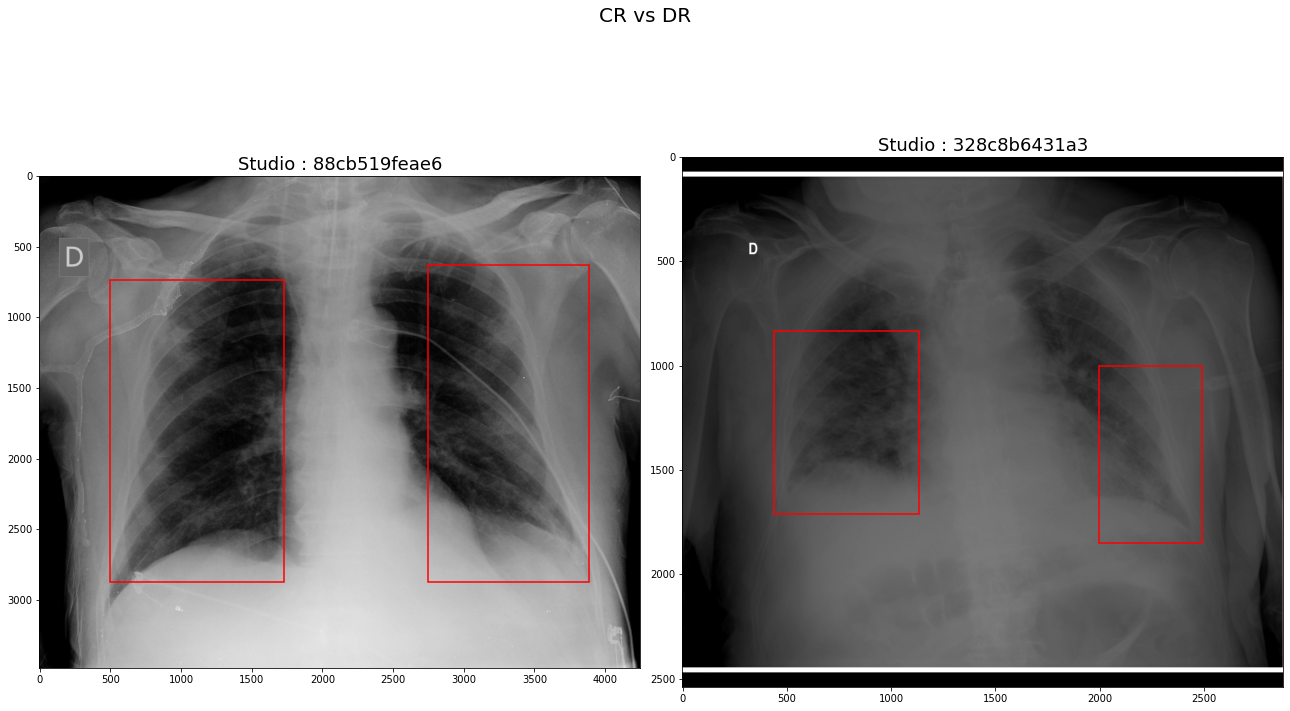

In [ ]:
#ejecutando funcion
despliega_muestras_modalidad(obtener_muestras_modalidad(), 'CR vs DR', True)

<center><h2><b>Cantidad de imagenes según su interpretación fotométrica</b></h2></center>
<center><h3>Existen dos interpretaciones:
<lu>
<li>MONOCROMO1 </li>
<li>MONOCROMO2</li>
</lu>
<b>MONOCROMO1:</b>indica que la escala de grises varía de brillante a oscuro con valores de píxeles ascendentes.<br>
<b>MONOCROMO2:</b>varía de oscuro a brillante con valores de píxeles ascendentes.

</h3></center>


In [ ]:
#Interpretación fotométrica En DICOM, a las imágenes monocromáticas se les da una interpretación fotométrica:
#'MONOCROMO1' (valores bajos=brillante, valores altos=tenue)  
#'MONOCROMO2' (valores bajos=oscuro, valores altos=brillante)

#veamos la relacion de cada una

pi_entrena = entrena_df_md['PhotometricInterpretation'].value_counts().reset_index().rename(columns={'index':'PhotometricInterpretation','PhotometricInterpretation':'Count'})
pi_entrena['Type'] = 'Entrenamiento'
pi_prueba = prueba_df_md['PhotometricInterpretation'].value_counts().reset_index().rename(columns={'index':'PhotometricInterpretation','PhotometricInterpretation':'Count'})
pi_prueba['Type'] = 'Prueba'
pi_df = pd.concat([pi_entrena, pi_prueba]).reset_index(drop=True)
bar_colors = ['#0918A8', '#CF130E']
pi_valores = list(pi_df.PhotometricInterpretation.unique())
fig = go.Figure()
for pi, color in zip(pi_valores, bar_colors):
    df = pi_df.loc[pi_df['PhotometricInterpretation'] == pi]
    fig.add_trace(go.Bar(
        x=df['Type'],
        y=df['Count'],
        name=pi,
        marker_color = color,
        #text = df['passenger_count_new'],
        #texttemplate='%{text:.2s}', 
        textposition='auto',
        marker_line_width=2.5, opacity=0.8,
        marker_line_color = color        
    ))
fig.update_layout(barmode='stack',
                  xaxis=dict(
                                tickmode = 'array',
                                 title=None,
                                 showgrid=False,
                                 zeroline=False,
                            ),
                      yaxis=dict(title='Conteo',
                                 showgrid=False,
                                 zeroline=False,
                                ), 
                      title = dict(text = 'Interpretación fotométrica de imagenes',
                                   xref = 'paper',
                                  ),
                      bargap=0.15, 
                    bargroupgap=0.1,
                     )     
fig.show()

In [ ]:
#visualizacion de ambos tipos de radiografias

#funcion que obtiene una muestra
def obtiene_muestra_foto(df, modalidad):
    np.random.seed(0)
    instancia = df.loc[(df['PhotometricInterpretation'] == modalidad) & (df['PatientSex'] == 'M')].sample(n=1)['StudyInstanceUID'].values[0]
    return instancia

#funcion que obtiene la comparacion
def obtiene_muestras_foto():
    muestras_modalidad = []
    muestras_modalidad.append(obtiene_muestra_foto(entrena_df_md,'MONOCHROME2'))
    muestras_modalidad.append(obtiene_muestra_foto(entrena_df_md,'MONOCHROME1'))
    muestras_estudio = []
    for id_instancia_estudio in muestras_modalidad:
        muestras = []
        imagen = {}
        #obtener imagen que coincide con id de estudio
        imagen_id = imagen_df.loc[imagen_df['StudyInstanceUID']==id_instancia_estudio]['id'].values[0].split('_')[0] 
        doc_nom = [cadena for cadena in todos_docs if imagen_id in cadena]
        imagen['id_estudio'] = id_instancia_estudio
        imagen['archivo_dicom'] = doc_nom[0]
        #obtener recuadros
        caja = None
        try:
            caja = literal_eval(imagen_df.loc[imagen_df['StudyInstanceUID']==id_instancia_estudio]['boxes'].values[0])
        except ValueError:
            pass
        imagen['boxes'] = caja
        muestras_estudio.append(imagen)
    return muestras_estudio


In [ ]:
#funcion que muestra imagenes de ambos tipod
def despliega_foto_muestras(muestras, titulo, dibuja_cajas=False):

    fig1, ax1 = plt.subplots(1,2, figsize=(18, 12), facecolor='w', edgecolor='b')
    fig1.subplots_adjust(hspace =.3, wspace=0.3)
    axs = ax1.ravel()
    for item, ax in zip(muestras, axs):
        dicom = read_file(item['archivo_dicom'], stop_before_pixels=False)
        img = dicom.pixel_array
        ax.imshow(img, cmap="gray")
        if dibuja_cajas == True and item['boxes'] is not None:
            for caja in item['boxes']:             
                rect = patches.Rectangle((caja['x'], caja['y']), caja['width'], caja['height'], linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        ax.set_title('Estudio : {}'.format(item['id_estudio']),fontsize = 18)
        
    plt.tight_layout(pad=1.0)
    plt.suptitle(titulo,fontsize = 20)
    plt.show()

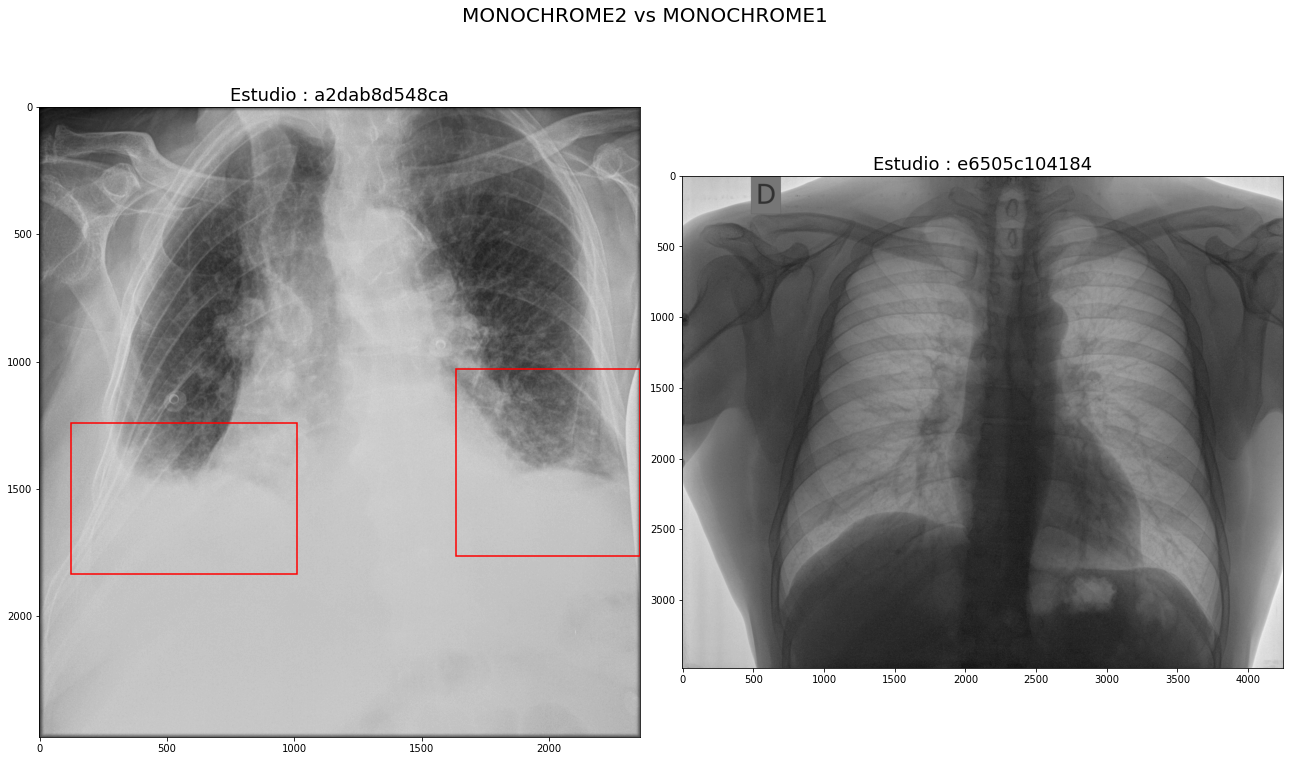

In [ ]:
#mostrando imagenes
despliega_foto_muestras(obtiene_muestras_foto(), 'MONOCHROME2 vs MONOCHROME1', True)

<center><h2><b>Información sobre las cajas de las imagenes</b></h2></center>

In [ ]:
#tomando copia de df de imagenes
img_df = imagen_df.copy()

#funcion que cuenta num de cajas
def contador_cajas(x):
    count=0
    bb_lst = literal_eval(x)
    for caja in bb_lst:
        count=count+1
    return count

#funcion que saca tamaño de caja
def caja_tam(x):
    tamaños= []
    bb_lst = literal_eval(x)
    for caja in bb_lst:
        w=caja['width']
        h=caja['height']
        tamaños.append(w*h)
    return tamaños

In [ ]:
img_df['boxes'] = img_df['boxes'].fillna('[]')
img_df['bb_count'] = img_df['boxes'].apply(lambda x: contador_cajas(x))
img_df['bb_size'] = img_df['boxes'].apply(lambda x: caja_tam(x))

bbs_lst = []
for index, row in img_df.iterrows():
    bbs_lst.extend(row['bb_size'])

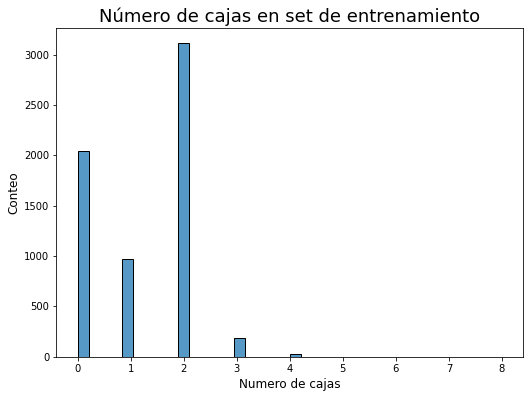

In [ ]:
fig1, ax1 = plt.subplots(1,1, figsize=(8, 6), facecolor='w', edgecolor='g')
fig1.subplots_adjust(hspace =.3, wspace=0.3)
sub_plot = sns.histplot(img_df['bb_count'], ax=ax1)
ax1.set_title('Número de cajas en set de entrenamiento',fontsize = 18)
ax1.set_xlabel('Numero de cajas', fontsize=12)
ax1.set_ylabel('Conteo', fontsize=12)
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.91)
plt.show()

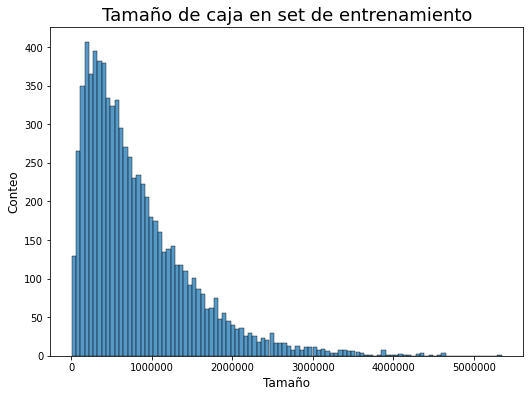

In [ ]:
fig1, ax1 = plt.subplots(1,1, figsize=(8, 6), facecolor='w', edgecolor='g')
fig1.subplots_adjust(hspace =.3, wspace=0.3)
sub_plot = sns.histplot(bbs_lst,bins=100, ax=ax1)
ax1.set_title('Tamaño de caja en set de entrenamiento',fontsize = 18)
ax1.set_xlabel('Tamaño', fontsize=12)
ax1.ticklabel_format(style='plain')
ax1.set_ylabel('Conteo', fontsize=12)
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.91)
plt.show()

In [ ]:
#definiendo df con resumen de indo de cajas
img_cajas_df = pd.DataFrame(columns=['image_id','study_ins_id','bb_count', 'bb_size'])

for index, rec in img_df.iterrows():
    renglon= {}
    renglon['image_id'] = rec['id'].split('_')[0]
    renglon['study_ins_id'] = rec['StudyInstanceUID']
    renglon['bb_count'] = rec['bb_count']    
    for caja in rec['bb_size']:
        renglon['bb_size'] = caja
        img_cajas_df = img_cajas_df.append(renglon, ignore_index=True)



In [ ]:
#visualizando info
img_cajas_df.head(10)

image_id  study_ins_id bb_count       bb_size
0  000a312787f2  5776db0cec75        2  1.968412e+06
1  000a312787f2  5776db0cec75        2  1.928301e+06
2  0012ff7358bc  9d514ce429a7        2  8.676086e+05
3  0012ff7358bc  9d514ce429a7        2  7.431218e+05
4  001398f4ff4f  28dddc8559b2        1  5.725921e+05
5  001bd15d1891  dfd9fdd85a3e        2  7.896840e+05
6  001bd15d1891  dfd9fdd85a3e        2  7.421867e+05
7  0022227f5adf  84543edc24c2        1  1.502339e+05
8  002e9b2128d0  0717c8ac304f        2  1.507766e+06
9  002e9b2128d0  0717c8ac304f        2  1.343308e+06

In [ ]:
fig = go.Figure()
cajas_colores = ['#0BA315','#09787D','#CF130E','#F47100']

for cajas_conteo, color in zip([1,2,3,4], cajas_colores):
    df = img_cajas_df.loc[img_cajas_df['bb_count']==cajas_conteo].reset_index(drop=True)
    fig.add_trace(go.Box(y=df['bb_size'], 
                             name='Conteo cajas : {}'.format(cajas_conteo), 
                             jitter=0.5,
                             whiskerwidth=0.6,
                             fillcolor=color,
                             marker_size=5,
                             line_width=1))
fig.update_layout(xaxis={'title' : None,'showgrid' :False},
                  yaxis=dict(title='Tamaño de cajas (Pixeles)',showgrid=False,zeroline=False),
                 title = 'Imagenes de entrenamiento -Tamaño de caja cuartiles')    
fig.show()

In [ ]:
#resumen de cajas en df
sg_df = pd.melt(estudio_df, id_vars=list(estudio_df.columns)[:1], value_vars=list(estudio_df.columns)[1:],
             var_name='etiqueta', value_name='valor')
sg_df = sg_df.loc[sg_df['valor']!=0]
sg_df['id_estudio'] = sg_df['id'].apply(lambda x : str(x).split('_')[0])
lbl_map = {'Negative for Pneumonia' : 'Negative',
 'Typical Appearance' : 'Typical',
 'Indeterminate Appearance' : 'Indeterminate', 
 'Atypical Appearance' : 'Atypical'}
sg_df['lbl'] = sg_df['etiqueta'].apply(lambda x: lbl_map[x])
slbl_map = dict(zip(sg_df.id_estudio, sg_df.lbl)) 
img_cajas_df['label'] = img_cajas_df['study_ins_id'].apply(lambda x: slbl_map[x])


In [ ]:
#visualizar df
img_cajas_df.head(10)

image_id  study_ins_id bb_count       bb_size          label
0  000a312787f2  5776db0cec75        2  1.968412e+06        Typical
1  000a312787f2  5776db0cec75        2  1.928301e+06        Typical
2  0012ff7358bc  9d514ce429a7        2  8.676086e+05        Typical
3  0012ff7358bc  9d514ce429a7        2  7.431218e+05        Typical
4  001398f4ff4f  28dddc8559b2        1  5.725921e+05       Atypical
5  001bd15d1891  dfd9fdd85a3e        2  7.896840e+05        Typical
6  001bd15d1891  dfd9fdd85a3e        2  7.421867e+05        Typical
7  0022227f5adf  84543edc24c2        1  1.502339e+05  Indeterminate
8  002e9b2128d0  0717c8ac304f        2  1.507766e+06        Typical
9  002e9b2128d0  0717c8ac304f        2  1.343308e+06        Typical

In [ ]:
#separando las cajas mas grandes
large_bb = img_cajas_df.sort_values('bb_size', ascending=False).head(20).reset_index(drop=True)
def encuentra_doc(img_id):
    imgs = [doc for doc in todos_docs if img_id in doc]
    return imgs[0]

large_bb['file'] = large_bb['image_id'].apply(lambda x : encuentra_doc(x))
large_bb = large_bb[['image_id','study_ins_id','label','file']]
lg_bb_dict = large_bb.set_index('image_id').T.to_dict('list')

<ipython-input-275-d9b5d1c823d2>:9: UserWarning:

DataFrame columns are not unique, some columns will be omitted.



In [ ]:
#visualizar cajas grandes
COLOR='white'
def muestra_imagen(img, figsize=None, ax=None, cmap="gray"):
    if not ax: 
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img, cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def dibuja_linea(o, lw):
    o.set_path_effects([path_effects.Stroke(linewidth=lw, foreground='black'), path_effects.Normal()])

    
def dibuja_texto(ax, x,y, txt, fontsize=14):
    text = ax.text(x,y, 
                   txt,
                  verticalalignment = 'top',
                  color=COLOR,
                  fontsize=fontsize,
                  weight='bold')

def dibuja_caja(ax, bb, label):
    for b in bb:
        patch = ax.add_patch(patches.Rectangle((b['x'],
                                           b['y']),
                                           b['width'],
                                           b['height'],
                        fill=False,
                         edgecolor='red',
                         lw=2))
       


def obten_img(doc):
    dicom = read_file(doc, stop_before_pixels=False)
    return dicom.pixel_array

def obten_caja(img_id):
    bb = literal_eval(imagen_df.loc[imagen_df['id'] == "{}_image".format(img_id)]['boxes'].values[0])
    return bb
        
def muestra_cajas(muestras, titulo, renglones=3, columnas=4):
    ''' Input : Dict of samples
    '''
    fig, axs = plt.subplots(renglones, columnas, figsize=(18, 12), facecolor='w', edgecolor='b')
    for i, ax in enumerate(axs.ravel()):
        img_id = list(muestras.keys())[i]
        data = list(muestras.values())[i]
        img = obten_img(data[2])
        bb = obten_caja(img_id)
        muestra_imagen(img, ax=ax)
        dibuja_caja(ax, bb, data[1])
        ax.set_title('{}, {}'.format(data[0],data[1]),fontsize = 14)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.91)
    plt.suptitle(titulo,fontsize = 20)
    plt.show()

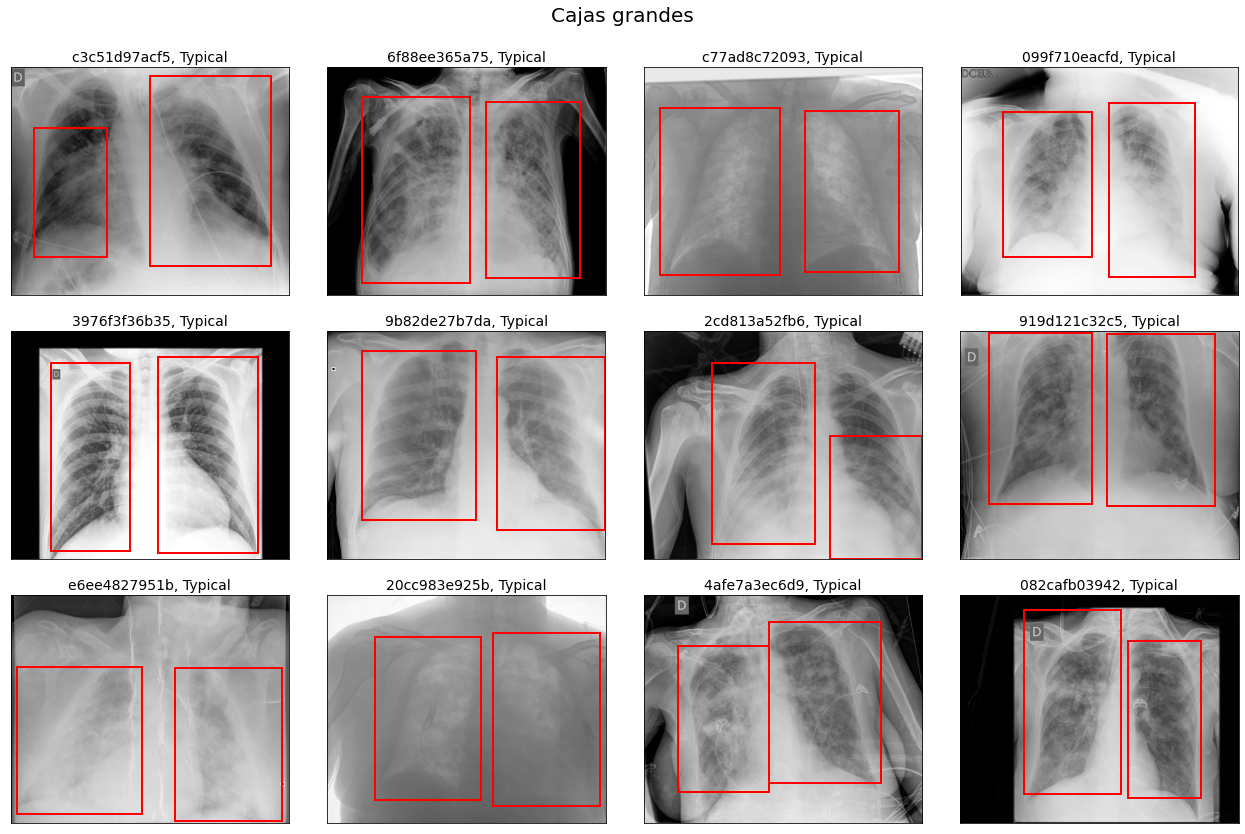

In [ ]:
muestra_cajas(lg_bb_dict, 'Cajas grandes')

<ipython-input-277-d213b251acb7>:5: UserWarning:

DataFrame columns are not unique, some columns will be omitted.



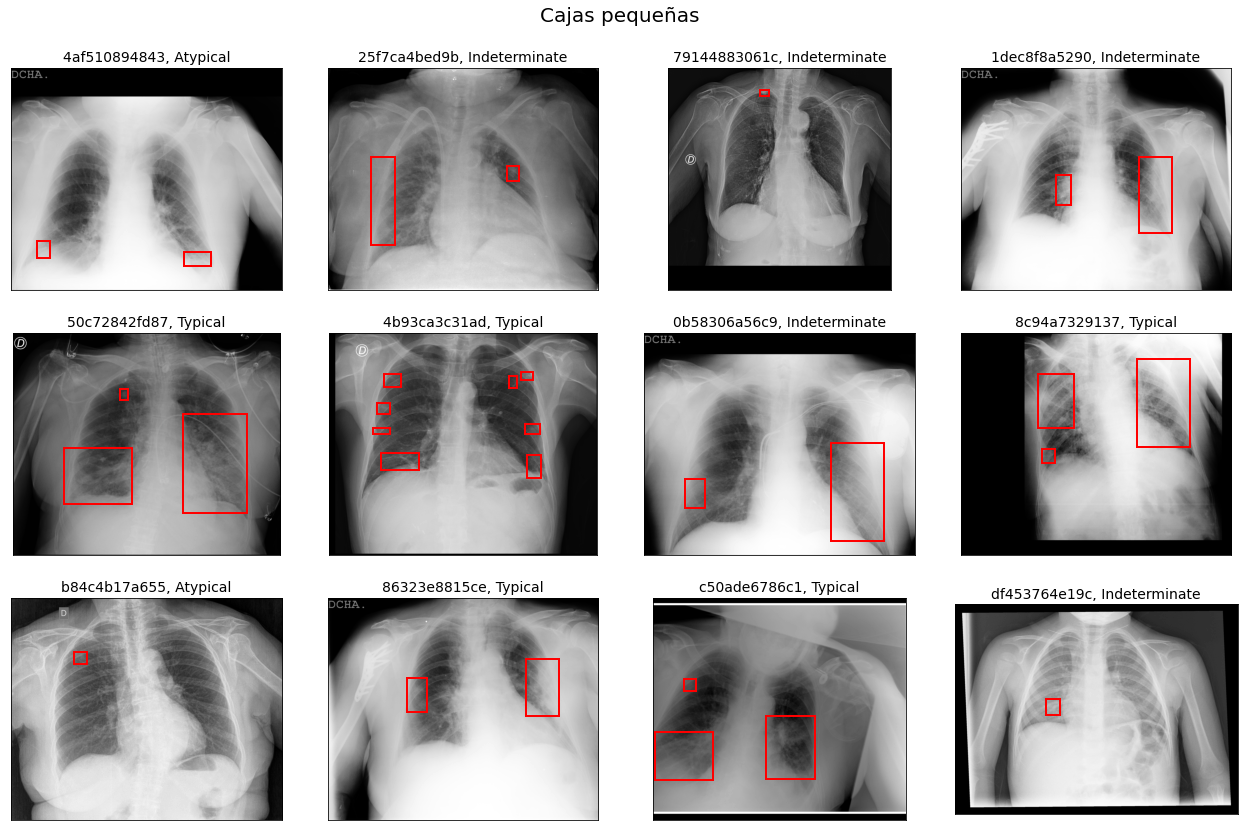

In [ ]:
#cajas pequeñas
small_bb = img_cajas_df.sort_values('bb_size', ascending=True).head(20).reset_index(drop=True)
small_bb['file'] = small_bb['image_id'].apply(lambda x : encuentra_doc(x))
small_bb = small_bb[['image_id','study_ins_id','label','file']]
sm_bb_dict = small_bb.set_index('image_id').T.to_dict('list')

muestra_cajas(sm_bb_dict, 'Cajas pequeñas')



<div><h1><b><center>Procesamiento</center></b></h1></div>

In [ ]:
#pasa a monocromo 2 y a png 
def monochromo_png(ruta):
  dicom=dcmread(ruta)
  img=dicom.pixel_array
  img=(np.maximum(img,0)/img.max())*255.0 #normaliza [0,255] si no salen png totalmente negros

  if dicom.PhotometricInterpretation=='MONOCHROME1':
    #pasa a monocromo2
    img=np.amax(img)-img

  #guarda como png
  cv2.imwrite(ruta.replace('.dcm','.png'),img)   

In [ ]:
#########################################################################solo se corre una vez ################################################################################
#pasando todas a monochromo2 (fondo negro) y guardando en png
for ruta in tqdm(todos_docs):
  monochromo_png(ruta)

 53%|█████▎    | 4005/7597 [1:07:28<52:12,  1.15it/s]/usr/local/lib/python3.8/dist-packages/pydicom/pixel_data_handlers/numpy_handler.py:250: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)
100%|██████████| 7597/7597 [2:07:29<00:00,  1.01s/it]


In [ ]:
#bucar y eliminar todas las png
for ruta in tqdm(todos_docs):
  ruta_png=ruta.replace('.dcm','.png')
  if os.path.exists(ruta_png):
    os.remove(ruta_png)
   
  

In [44]:
def VerPNG(ruta,df):
  id=ruta.split('/')[-1].replace('.dcm','')
  datos=df.loc[df['id']==id+'_image']
  imagen=imagen=cv2.imread(ruta.replace('.dcm','.png'))
  fig, ax = plt.subplots(figsize=(18, 5), facecolor='w', edgecolor='b')
  ax.imshow(imagen,cmap="gray")
  if 'boxes' in datos and datos['boxes'] is not None and not pd.isna(datos['boxes']).bool():
    bboxes=literal_eval(datos['boxes'].values[0])
    for bbox in bboxes:
        rect = patches.Rectangle((bbox['x'],bbox['y']),bbox['width'],bbox['height'], linewidth=1.5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
         

  

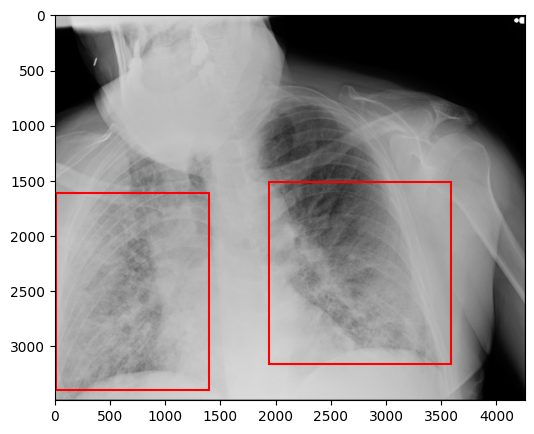

In [45]:
VerPNG('/content/drive/MyDrive/covid/train/05f85b86cdd6/799dd41241c0/6ea732c63929.dcm',imagen_df)
#/content/drive/MyDrive/covid/train/20cc983e925b/9d68b678f54c/5d2ce88dc192.dcm

In [ ]:
#viendo como funciona función que escala imagen y bbox hay que aplicarle esta funcion a cada imagen para reescalar

def escalando_im_bb(ruta, h, w, df):
    """
    :parametro ruta: ruta de imagen original
    :parametro h: altura nueva
    :parametro w: ancho nuevo
    :patametro df: informacion de las imagenes en csv
    :regresa tranformed: diccionario con imagen y bbox escalados
    :regresa datos: datos del csv asociadas a la imagen oroiginal
    :regresa imagen: magen original
    """
    # create resize transform pipeline
    imagen=cv2.imread(ruta.replace('.dcm','.png'))
    id=ruta.split('/')[-1].replace('.dcm','')
    datos=df.loc[df['id']==id+'_image']
    if 'boxes' in datos and datos['boxes'] is not None and not pd.isna(datos['boxes']).bool():
      bboxes=literal_eval(datos['boxes'].values[0])
      arreglo_bbox=np.zeros((len(bboxes),5))
      i=0
      for bbox in bboxes:
        arreglo_bbox[i][0]=bbox['x']
        arreglo_bbox[i][1]=bbox['y']
        arreglo_bbox[i][2]=bbox['width']
        arreglo_bbox[i][3]=bbox['height']
        arreglo_bbox[i][4]=111 #etiqueta asociada cambiar por etiqueta
        i=i+1
        
      transform = A.Compose([A.Resize(height=h, width=w, always_apply=True)],bbox_params=A.BboxParams(format='coco'))
      transformed = transform(image=imagen, bboxes=arreglo_bbox)

    return transformed , datos, imagen

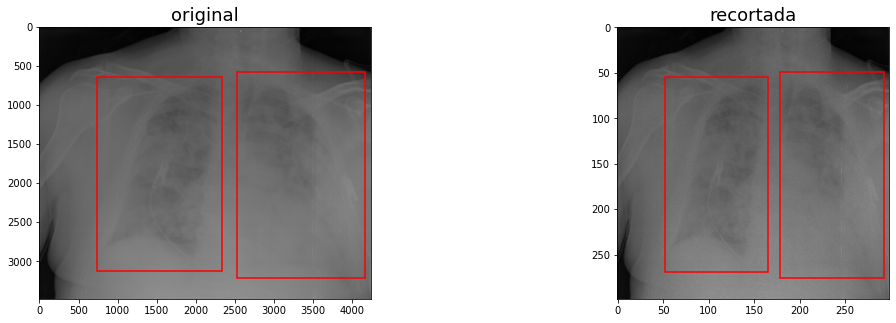

In [ ]:
escalados, datos, imagen_original=escalando_im_bb('/content/drive/MyDrive/covid/train/20cc983e925b/9d68b678f54c/5d2ce88dc192.dcm',299,299,imagen_df)

#visualizando imagen original y la modificada
fig, ax = plt.subplots(1,2,figsize=(18, 5), facecolor='w', edgecolor='b')
axs=ax.ravel()
axs[0].imshow(imagen_original,cmap="gray")
axs[0].set_title('original',fontsize = 18)
axs[1].imshow(escalados['image'],cmap="gray")
axs[1].set_title('recortada',fontsize = 18)
if 'boxes' in datos and datos['boxes'] is not None and not pd.isna(datos['boxes']).bool():
  bboxes=literal_eval(datos['boxes'].values[0])
  for bbox in bboxes:
    rect = patches.Rectangle((bbox['x'],bbox['y']),bbox['width'],bbox['height'], linewidth=1.5, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)

  for bbox in escalados['bboxes']:
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3], linewidth=1.5, edgecolor='r', facecolor='none')
    axs[1].add_patch(rect)
   

In [ ]:
#########################################################solo se ejecuta una vez######################################################################
#rutas que no contemplan imagenes sin bboxes
def rutas_deteccion(rutas,imagen_df,estudio_df):
  deteccion_r=[]  
  for ruta in rutas:
    bboxes, _ =obtiene_datos(ruta,imagen_df,estudio_df)
    if bboxes is not None:
      deteccion_r.append(ruta)

  rutas_deteccion=pd.DataFrame()
  rutas_deteccion['rutas']=deteccion_r
  rutas_deteccion.to_csv('/content/drive/MyDrive/rutas_deteccion.txt', index=False)


rutas_deteccion(rutas_entrenamiento,imagen_df,estudio_df)